# Term Deposit Marketing Prediction Models

This notebook builds two predictive models for term deposit marketing:
1. **Pre-Call Model**: Predicts which customers to call before making any calls (excludes campaign-related features)
2. **Post-Call Model**: Predicts which customers to focus on after initial contact (includes all features)

We'll compare multiple models and select the top 3 for each scenario.

## 1. Setup and Data Preparation

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc,
)
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Import models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Set display options
pd.set_option("display.max_columns", None)
sns.set_style("whitegrid")


In [2]:
# Load the dataset
file_path = "term-deposit-marketing-2020.csv"
df = pd.read_csv(file_path)
print(f"Data loaded: {df.shape[0]} rows, {df.shape[1]} columns")
print("Columns:", df.columns.tolist())
df.head()


Data loaded: 40000 rows, 14 columns
Columns: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'y']


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [3]:
# Check for missing values and duplicates
missing = df.isnull().sum()
duplicates = df.duplicated().sum()
print(f"Missing values per column:\n{missing}\n")
print(f"Number of duplicated rows: {duplicates}\n")


Missing values per column:
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
y            0
dtype: int64

Number of duplicated rows: 0



In [4]:
# Check class distribution
df["y"].value_counts(normalize=True).mul(100).round(2)


y
no     92.76
yes     7.24
Name: proportion, dtype: float64

### Identify Campaign-Related Features

For our first model, we need to exclude campaign-related features that would not be available before making calls.

In [5]:
# Define campaign-related features that will be excluded from Model 1
campaign_features = ["duration", "day", "month", "campaign"]

# Define features for Model 1 (pre-call)
model1_features = [
    col for col in df.columns if col not in campaign_features and col != "y"
]
print("Features for Model 1 (pre-call):\n", model1_features)

# Define features for Model 2 (post-call)
model2_features = [col for col in df.columns if col != "y"]
print("\nFeatures for Model 2 (post-call):\n", model2_features)


Features for Model 1 (pre-call):
 ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact']

Features for Model 2 (post-call):
 ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign']


## 2. Model 1: Pre-Call Prediction

This model will help predict which customers to call before making any calls, using only features available before the campaign.

In [6]:
# Create dataset for Model 1
model1_data = df[model1_features + ["y"]].copy()
model1_data.head()


,age,job,marital,education,default,balance,housing,loan,contact,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,no


In [7]:
# Prepare data for Model 1
# Convert target to binary
model1_data["y_binary"] = model1_data["y"].map({"yes": 1, "no": 0})

# Split features and target
X1 = model1_data.drop(["y", "y_binary"], axis=1)
y1 = model1_data["y_binary"]

# Identify categorical and numerical features
categorical_features = X1.select_dtypes(include=["object"]).columns.tolist()
numerical_features = X1.select_dtypes(include=["int64", "float64"]).columns.tolist()

print(f"Categorical features: {categorical_features}")
print(f"Numerical features: {numerical_features}")

# Create preprocessing pipeline
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

numerical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Split data into train and test sets
X1_train, X1_test, y1_train, y1_test = train_test_split(
    X1, y1, test_size=0.2, random_state=42, stratify=y1
)


Categorical features: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact']
Numerical features: ['age', 'balance']


In [8]:
# Define models to evaluate for Model 1
models1 = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier(),
}


### Evaluate Models for Pre-Call Prediction

In [9]:
# Function to evaluate models with classification report and confusion matrix
def evaluate_model(model_name, model, X_train, X_test, y_train, y_test, preprocessor):
    # Create pipeline with preprocessing and model
    pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", model)])

    # Train the model
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

    # Classification report
    print(f"\n{model_name} - Classification Report:")
    report = classification_report(y_test, y_pred)
    print(report)

    # Confusion Matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["No", "Yes"],
        yticklabels=["No", "Yes"],
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    # Calculate metrics
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = (
        2 * (precision * recall) / (precision + recall)
        if (precision + recall) > 0
        else 0
    )
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.3f})")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend(loc="lower right")
    plt.show()

    print(f"\nObservations for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"True Positives: {tp} - Correctly predicted subscribers")
    print(f"False Positives: {fp} - Incorrectly predicted as subscribers")
    print(f"True Negatives: {tn} - Correctly predicted non-subscribers")
    print(f"False Negatives: {fn} - Missed potential subscribers")

    # Try to get feature importance if available
    if hasattr(model, "feature_importances_") or hasattr(model, "coef_"):
        # Get feature names after preprocessing
        feature_names = []
        for name, transformer, features in preprocessor.transformers_:
            if name == "cat":
                # Get one-hot encoded feature names
                encoder = transformer.named_steps["onehot"]
                encoded_features = encoder.get_feature_names_out(features)
                feature_names.extend(encoded_features)
            else:
                feature_names.extend(features)

        # Get feature importance
        if hasattr(model, "feature_importances_"):
            importances = model.feature_importances_
        elif hasattr(model, "coef_"):
            importances = np.abs(model.coef_[0])
        else:
            importances = None

        if importances is not None and len(importances) == len(feature_names):
            # Plot feature importance
            plt.figure(figsize=(10, 8))
            indices = np.argsort(importances)[-20:]  # Top 20 features
            plt.barh(range(len(indices)), importances[indices])
            plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
            plt.xlabel("Feature Importance")
            plt.title(f"Top 20 Feature Importance - {model_name}")
            plt.tight_layout()
            plt.show()

    return {
        "model": model_name,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc,
        "tp": tp,
        "fp": fp,
        "tn": tn,
        "fn": fn,
        "pipeline": pipeline,
    }




Evaluating Logistic Regression for Model 1 (Pre-Call)...

Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      7421
           1       0.00      0.00      0.00       579

    accuracy                           0.93      8000
   macro avg       0.46      0.50      0.48      8000
weighted avg       0.86      0.93      0.89      8000



c:\Users\Osama\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Osama\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Osama\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

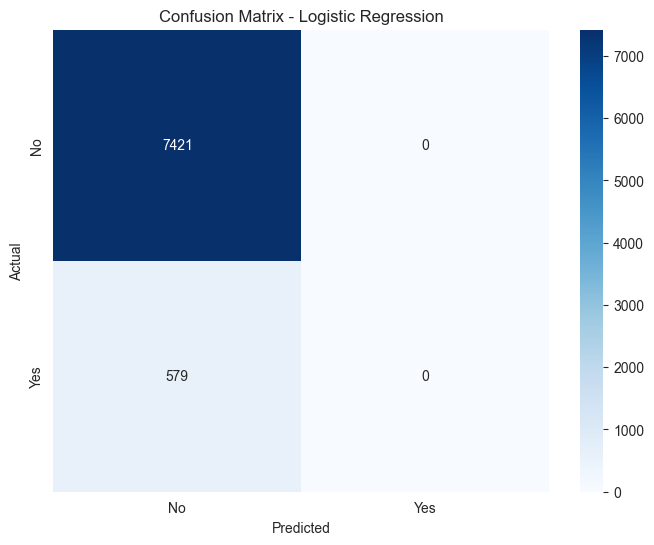

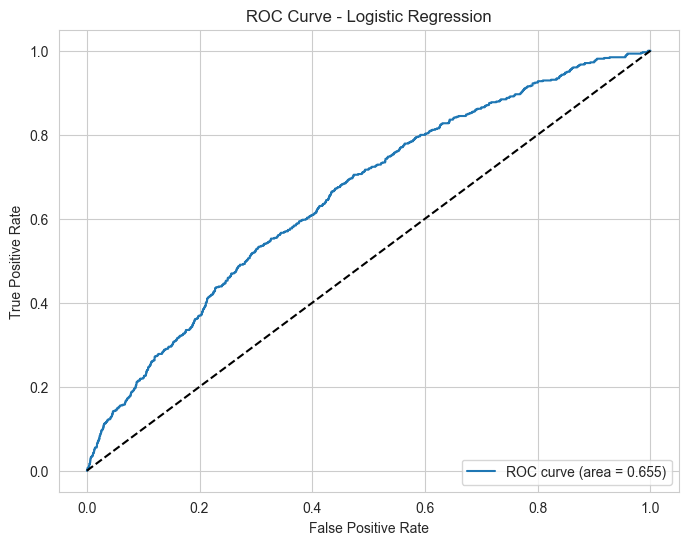


Observations for Logistic Regression:
Accuracy: 0.9276
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
ROC AUC: 0.6549
True Positives: 0 - Correctly predicted subscribers
False Positives: 0 - Incorrectly predicted as subscribers
True Negatives: 7421 - Correctly predicted non-subscribers
False Negatives: 579 - Missed potential subscribers


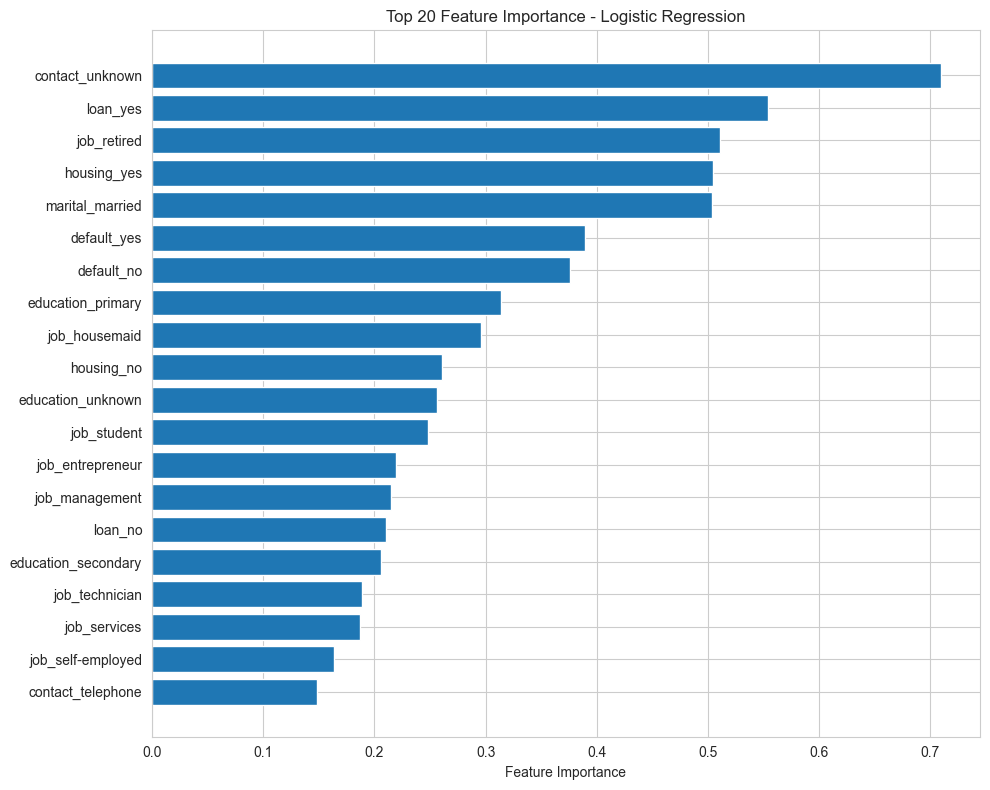



Evaluating Random Forest for Model 1 (Pre-Call)...

Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.96      7421
           1       0.23      0.07      0.10       579

    accuracy                           0.92      8000
   macro avg       0.58      0.52      0.53      8000
weighted avg       0.88      0.92      0.89      8000



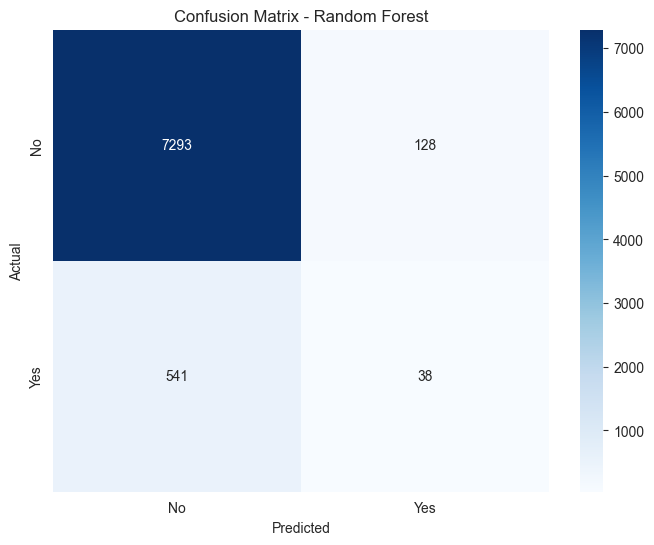

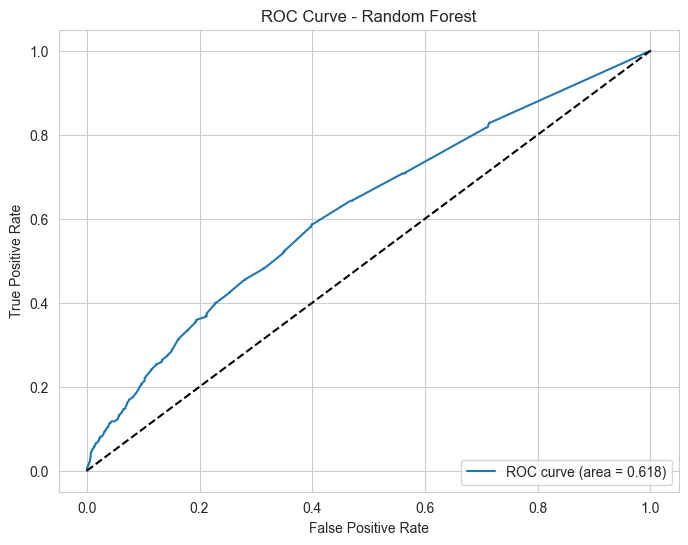


Observations for Random Forest:
Accuracy: 0.9164
Precision: 0.2289
Recall: 0.0656
F1 Score: 0.1020
ROC AUC: 0.6182
True Positives: 38 - Correctly predicted subscribers
False Positives: 128 - Incorrectly predicted as subscribers
True Negatives: 7293 - Correctly predicted non-subscribers
False Negatives: 541 - Missed potential subscribers


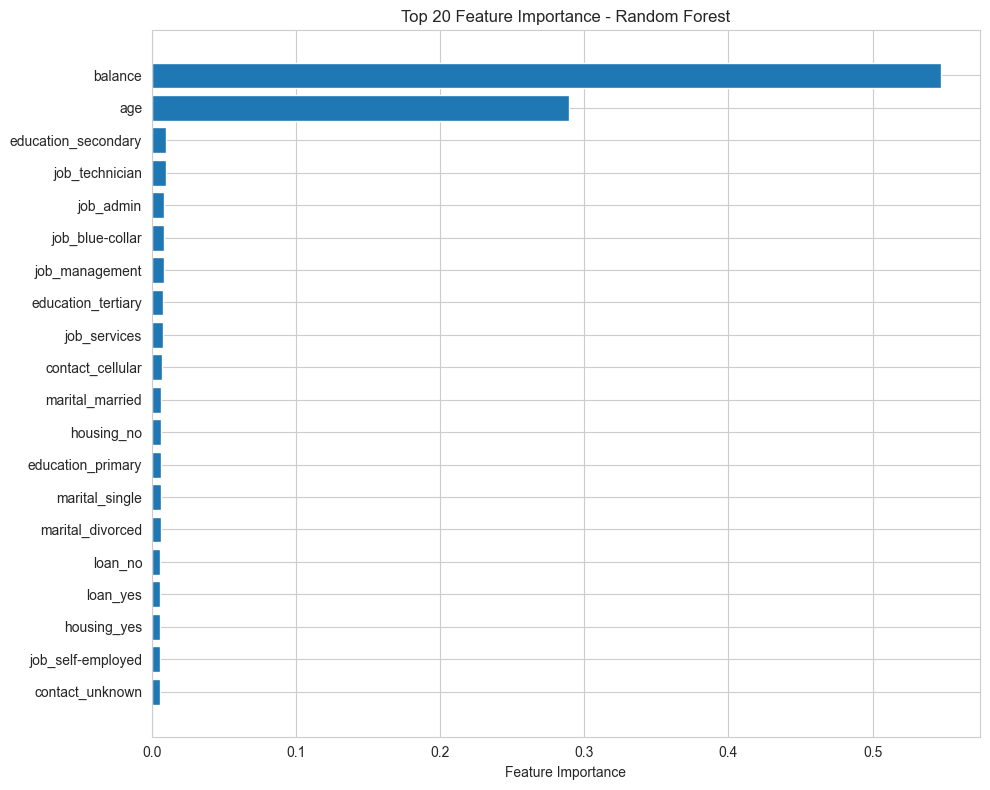



Evaluating Gradient Boosting for Model 1 (Pre-Call)...

Gradient Boosting - Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      7421
           1       0.36      0.01      0.01       579

    accuracy                           0.93      8000
   macro avg       0.65      0.50      0.49      8000
weighted avg       0.89      0.93      0.89      8000



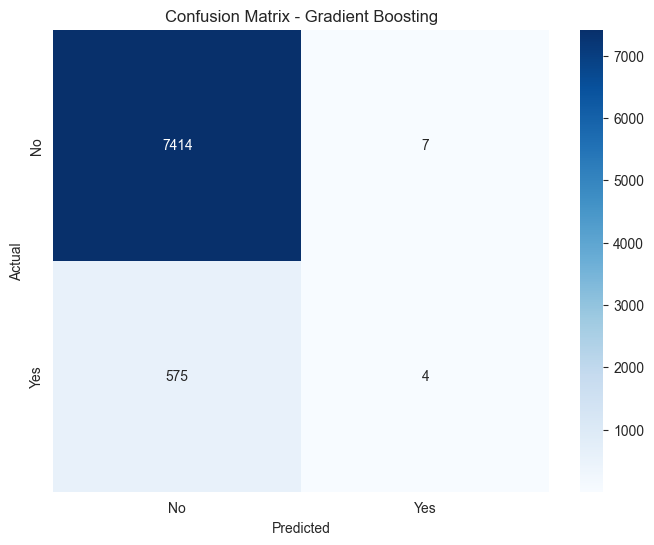

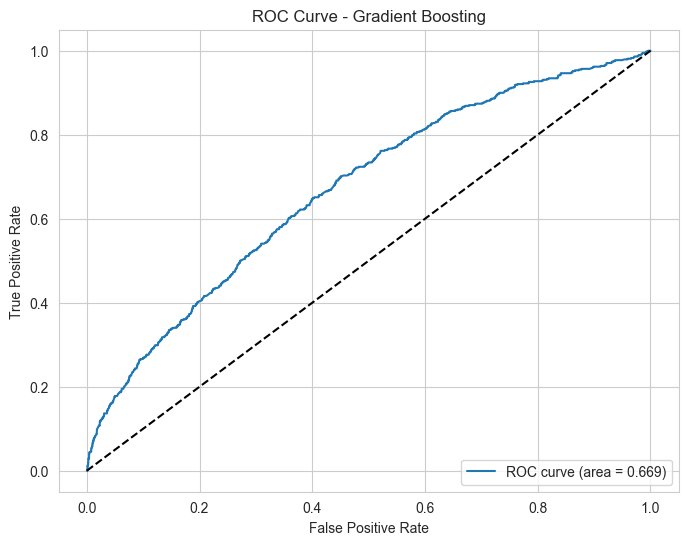


Observations for Gradient Boosting:
Accuracy: 0.9273
Precision: 0.3636
Recall: 0.0069
F1 Score: 0.0136
ROC AUC: 0.6695
True Positives: 4 - Correctly predicted subscribers
False Positives: 7 - Incorrectly predicted as subscribers
True Negatives: 7414 - Correctly predicted non-subscribers
False Negatives: 575 - Missed potential subscribers


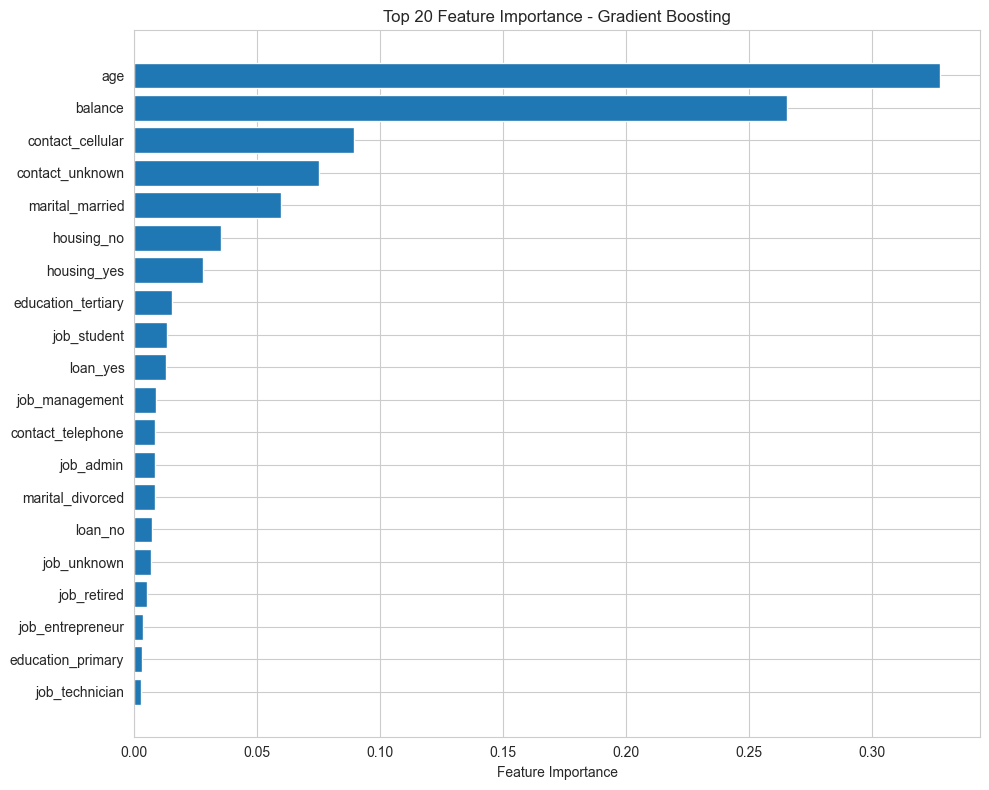



Evaluating XGBoost for Model 1 (Pre-Call)...

XGBoost - Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      7421
           1       0.25      0.01      0.02       579

    accuracy                           0.93      8000
   macro avg       0.59      0.50      0.49      8000
weighted avg       0.88      0.93      0.89      8000



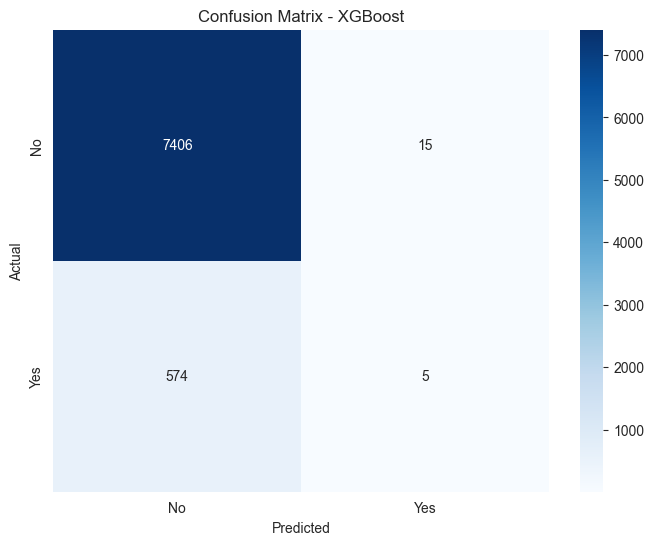

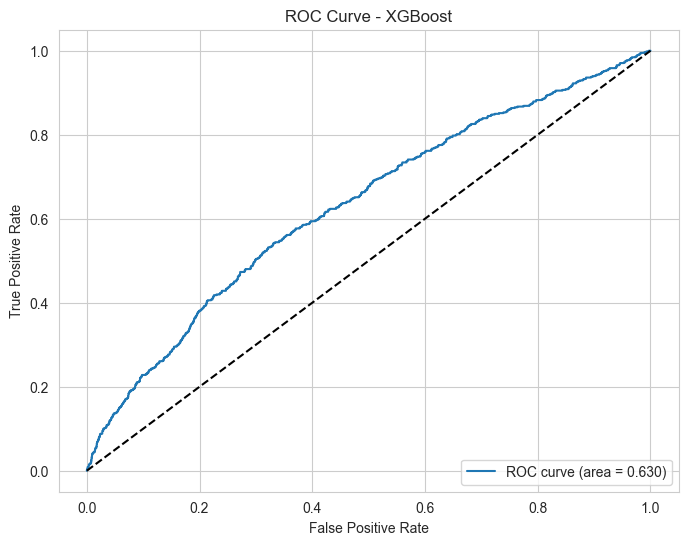


Observations for XGBoost:
Accuracy: 0.9264
Precision: 0.2500
Recall: 0.0086
F1 Score: 0.0167
ROC AUC: 0.6301
True Positives: 5 - Correctly predicted subscribers
False Positives: 15 - Incorrectly predicted as subscribers
True Negatives: 7406 - Correctly predicted non-subscribers
False Negatives: 574 - Missed potential subscribers


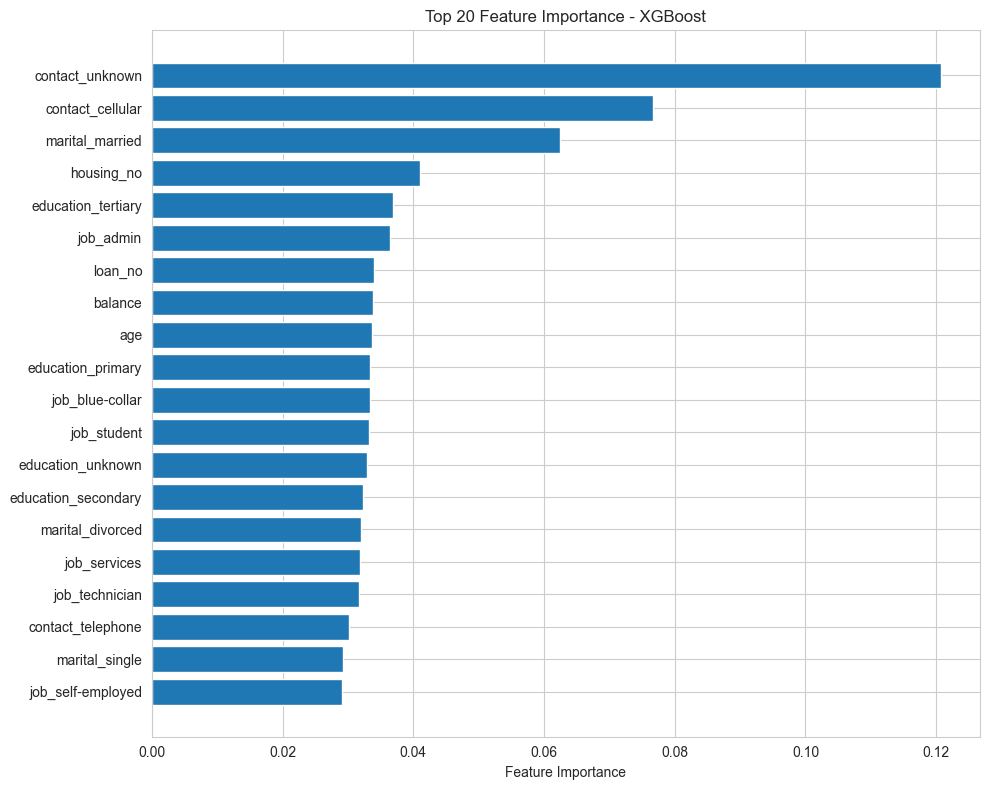



Evaluating LightGBM for Model 1 (Pre-Call)...
[LightGBM] [Info] Number of positive: 2317, number of negative: 29683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001169 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 375
[LightGBM] [Info] Number of data points in the train set: 32000, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.072406 -> initscore=-2.550301
[LightGBM] [Info] Start training from score -2.550301

LightGBM - Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      7421
           1       0.30      0.01      0.01       579

    accuracy                           0.93      8000
   macro avg       0.61      0.50      0.49      8000
weighted avg       0.88      0.93      0.89      8000



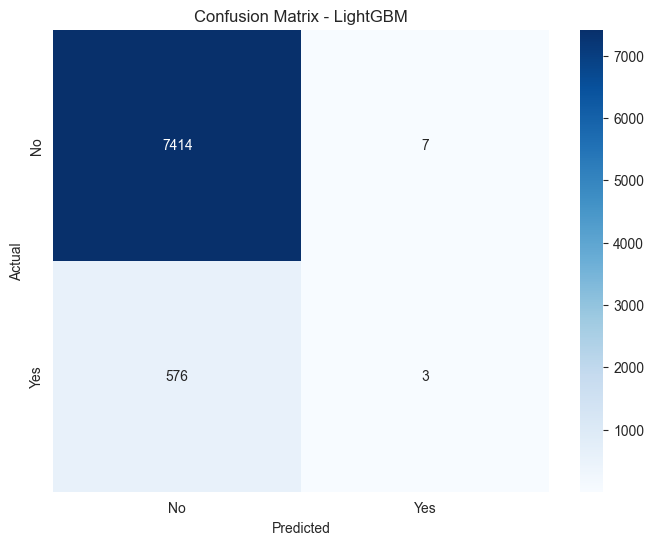

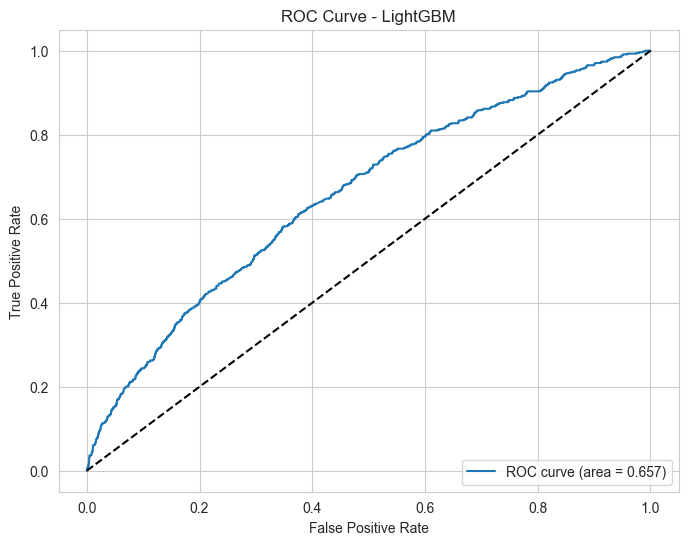


Observations for LightGBM:
Accuracy: 0.9271
Precision: 0.3000
Recall: 0.0052
F1 Score: 0.0102
ROC AUC: 0.6572
True Positives: 3 - Correctly predicted subscribers
False Positives: 7 - Incorrectly predicted as subscribers
True Negatives: 7414 - Correctly predicted non-subscribers
False Negatives: 576 - Missed potential subscribers


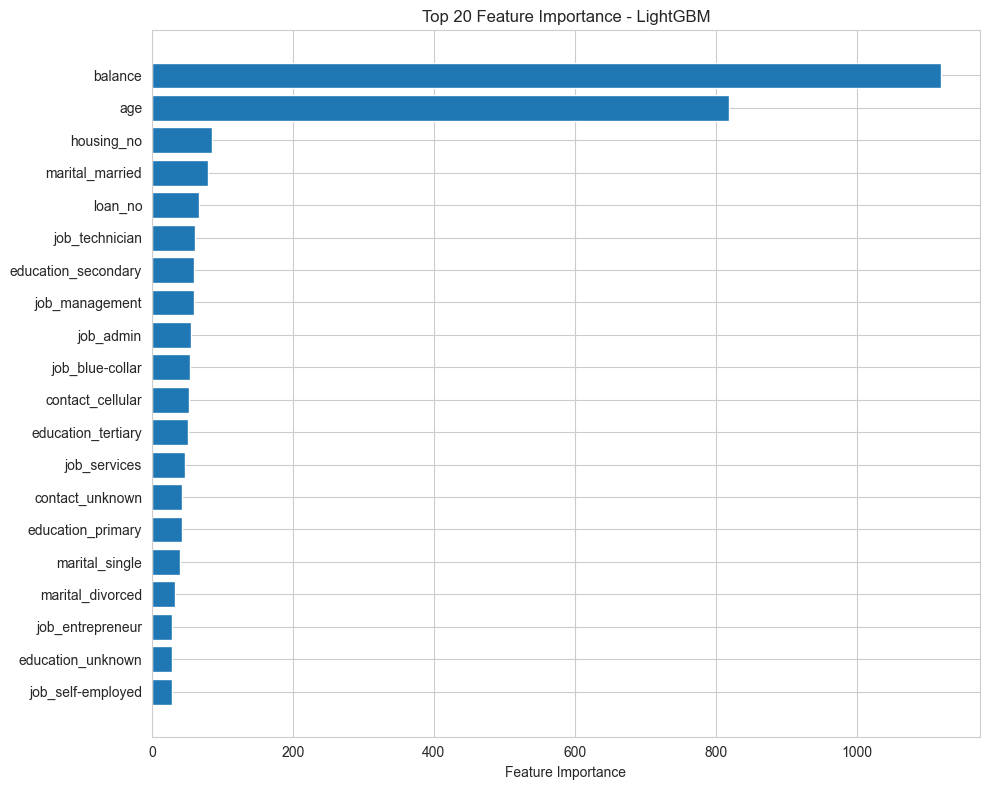



Evaluating Decision Tree for Model 1 (Pre-Call)...

Decision Tree - Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      7421
           1       0.10      0.11      0.11       579

    accuracy                           0.87      8000
   macro avg       0.52      0.52      0.52      8000
weighted avg       0.87      0.87      0.87      8000



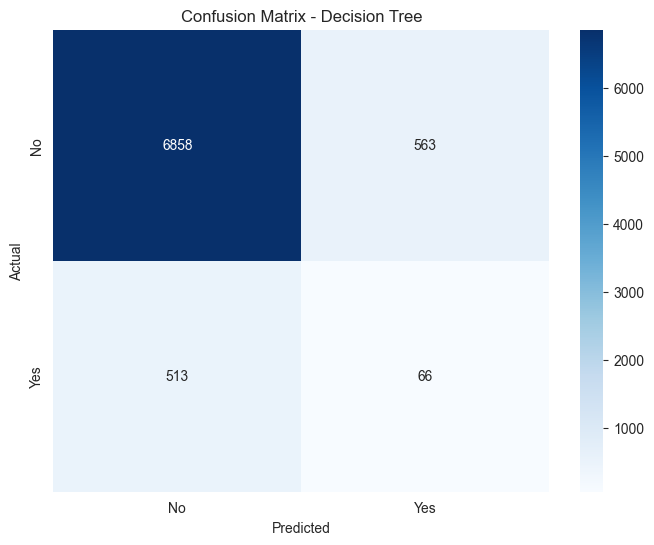

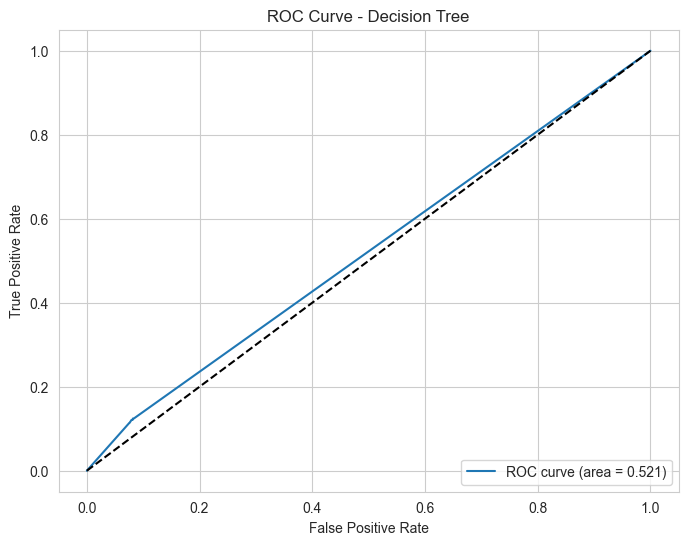


Observations for Decision Tree:
Accuracy: 0.8655
Precision: 0.1049
Recall: 0.1140
F1 Score: 0.1093
ROC AUC: 0.5205
True Positives: 66 - Correctly predicted subscribers
False Positives: 563 - Incorrectly predicted as subscribers
True Negatives: 6858 - Correctly predicted non-subscribers
False Negatives: 513 - Missed potential subscribers


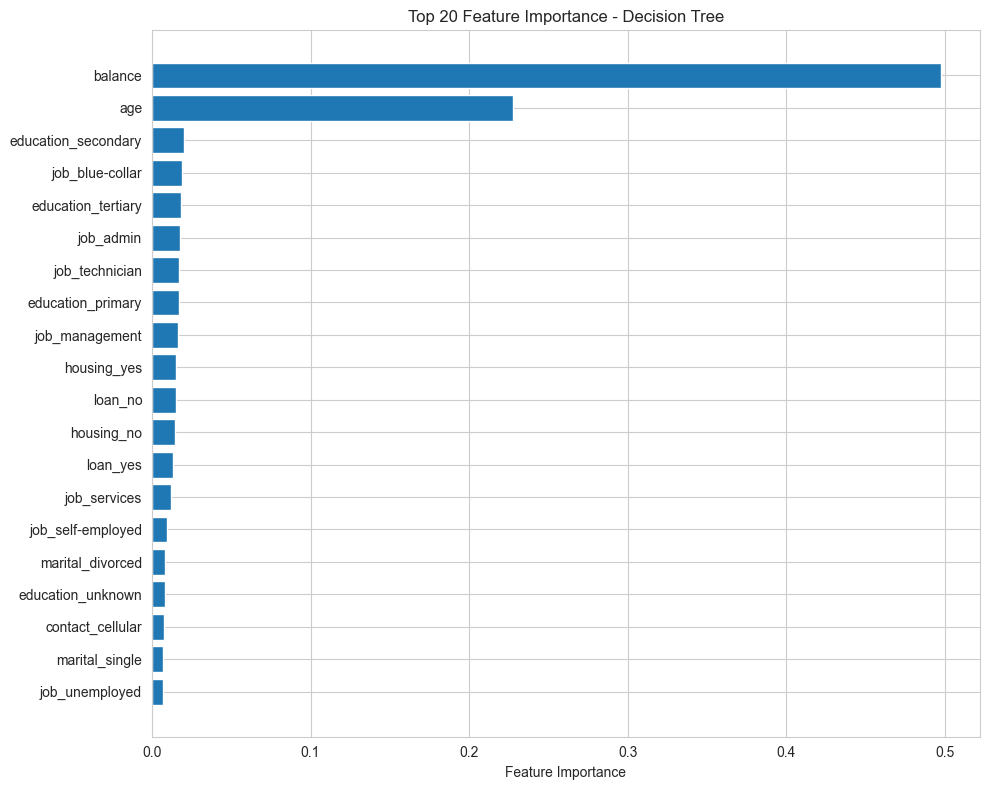



Evaluating AdaBoost for Model 1 (Pre-Call)...


c:\Users\Osama\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



AdaBoost - Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      7421
           1       0.18      0.00      0.01       579

    accuracy                           0.93      8000
   macro avg       0.55      0.50      0.48      8000
weighted avg       0.87      0.93      0.89      8000



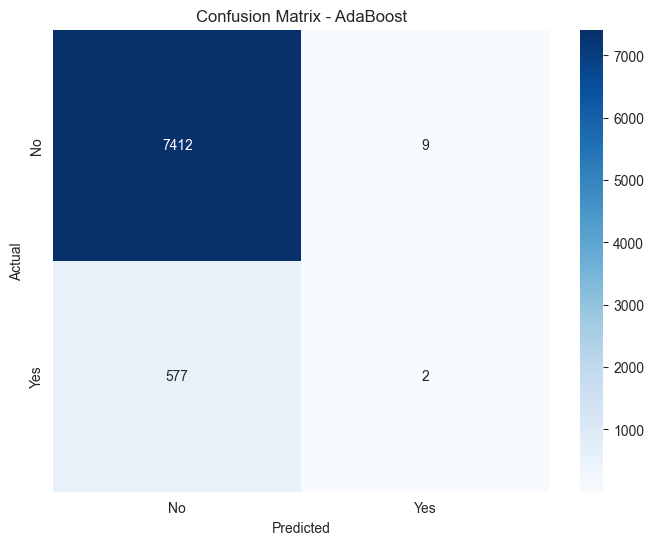

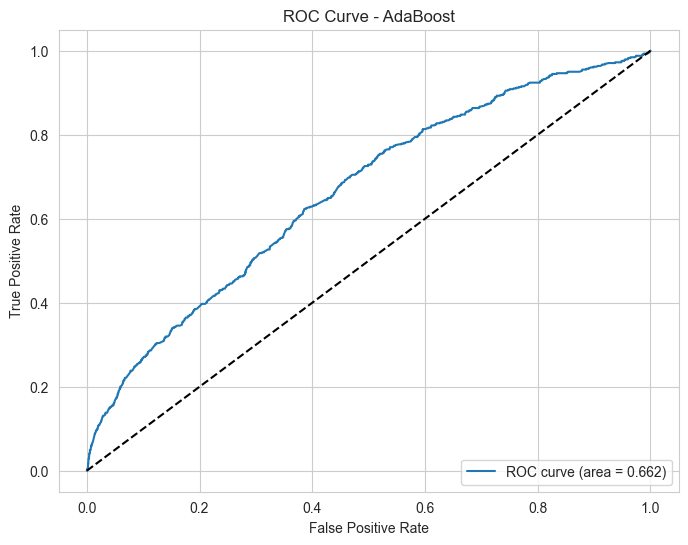


Observations for AdaBoost:
Accuracy: 0.9267
Precision: 0.1818
Recall: 0.0035
F1 Score: 0.0068
ROC AUC: 0.6624
True Positives: 2 - Correctly predicted subscribers
False Positives: 9 - Incorrectly predicted as subscribers
True Negatives: 7412 - Correctly predicted non-subscribers
False Negatives: 577 - Missed potential subscribers


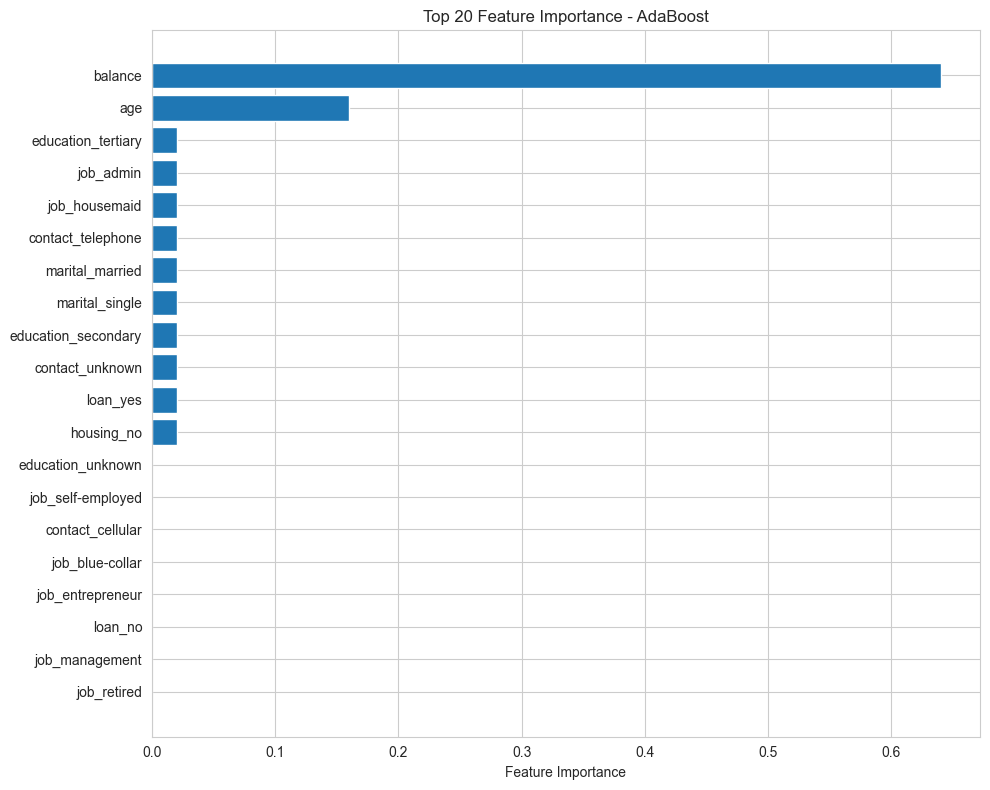



Evaluating SVM for Model 1 (Pre-Call)...

SVM - Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      7421
           1       0.00      0.00      0.00       579

    accuracy                           0.93      8000
   macro avg       0.46      0.50      0.48      8000
weighted avg       0.86      0.93      0.89      8000



c:\Users\Osama\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Osama\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Osama\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

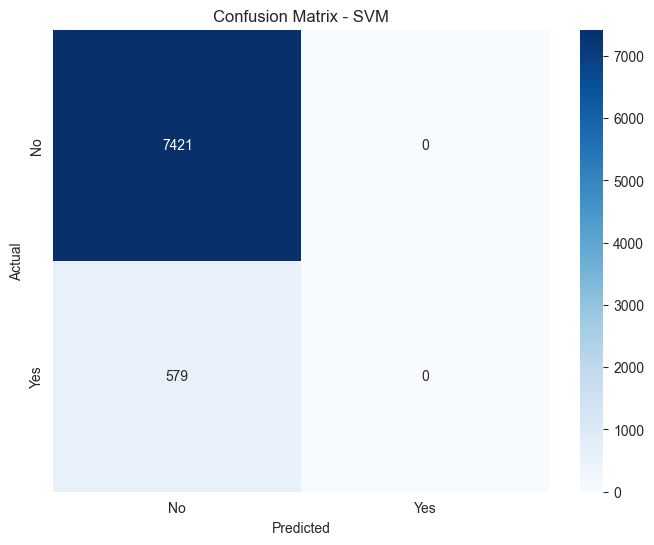

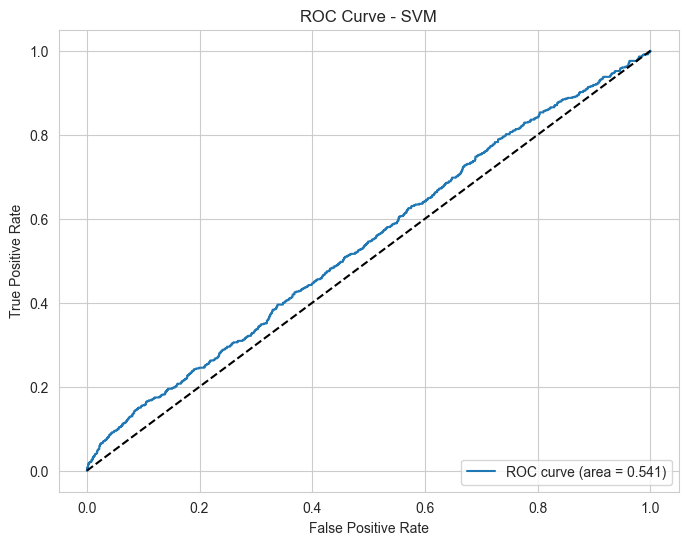


Observations for SVM:
Accuracy: 0.9276
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
ROC AUC: 0.5408
True Positives: 0 - Correctly predicted subscribers
False Positives: 0 - Incorrectly predicted as subscribers
True Negatives: 7421 - Correctly predicted non-subscribers
False Negatives: 579 - Missed potential subscribers


Evaluating KNN for Model 1 (Pre-Call)...

KNN - Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      7421
           1       0.13      0.01      0.03       579

    accuracy                           0.92      8000
   macro avg       0.53      0.50      0.49      8000
weighted avg       0.87      0.92      0.89      8000



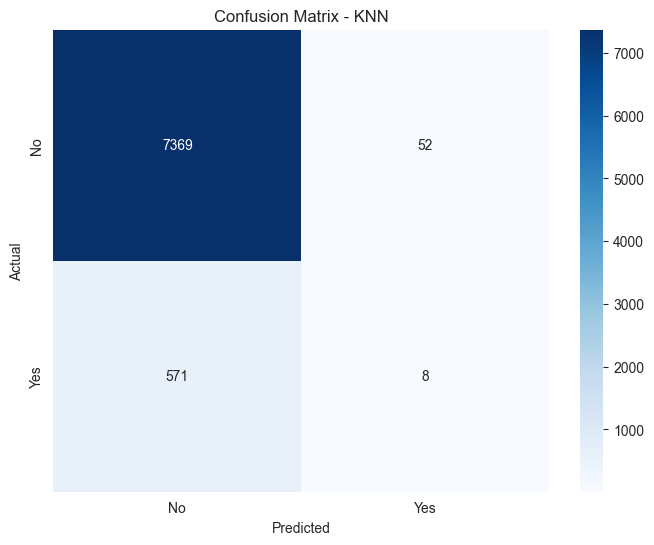

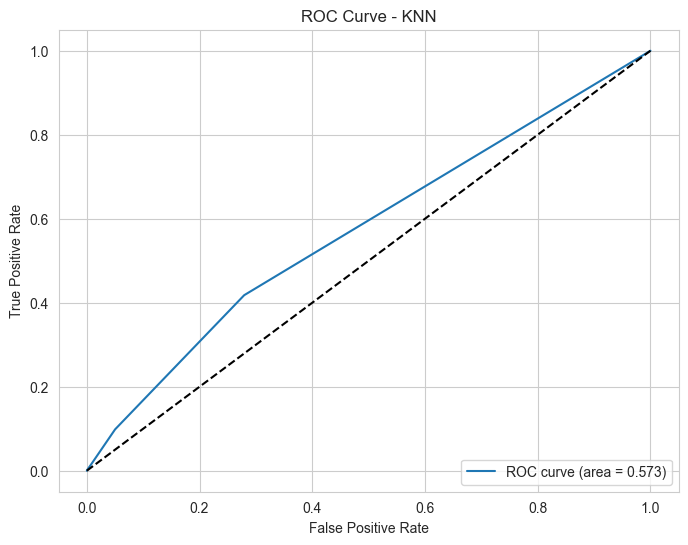


Observations for KNN:
Accuracy: 0.9221
Precision: 0.1333
Recall: 0.0138
F1 Score: 0.0250
ROC AUC: 0.5726
True Positives: 8 - Correctly predicted subscribers
False Positives: 52 - Incorrectly predicted as subscribers
True Negatives: 7369 - Correctly predicted non-subscribers
False Negatives: 571 - Missed potential subscribers


In [10]:
# Evaluate each model for Model 1
model1_results = []

for name, model in models1.items():
    print(f"\n\nEvaluating {name} for Model 1 (Pre-Call)...")
    try:
        result = evaluate_model(
            name, model, X1_train, X1_test, y1_train, y1_test, preprocessor
        )
        model1_results.append(result)
    except Exception as e:
        print(f"Error evaluating {name}: {str(e)}")


In [11]:
# Create a summary DataFrame for Model 1 results
model1_summary = pd.DataFrame(model1_results)
model1_summary = model1_summary.drop(
    "pipeline", axis=1
)  # Drop pipeline object for display
model1_summary = model1_summary.sort_values("f1", ascending=False)  # Sort by F1 score
model1_summary


,model,accuracy,precision,recall,f1,roc_auc,tp,fp,tn,fn
5,Decision Tree,0.865500,0.104928,0.113990,0.109272,0.520538,66,563,6858,513
1,Random Forest,0.916375,0.228916,0.065630,0.102013,0.618230,38,128,7293,541
8,KNN,0.922125,0.133333,0.013817,0.025039,0.572648,8,52,7369,571
3,XGBoost,0.926375,0.250000,0.008636,0.016694,0.630142,5,15,7406,574
2,Gradient Boosting,0.927250,0.363636,0.006908,0.013559,0.669479,4,7,7414,575
4,LightGBM,0.927125,0.300000,0.005181,0.010187,0.657204,3,7,7414,576
6,AdaBoost,0.926750,0.181818,0.003454,0.006780,0.662427,2,9,7412,577
0,Logistic Regression,0.927625,0.000000,0.000000,0.000000,0.654898,0,0,7421,579
7,SVM,0.927625,0.000000,0.000000,0.000000,0.540789,0,0,7421,579


<Figure size 1200x600 with 0 Axes>

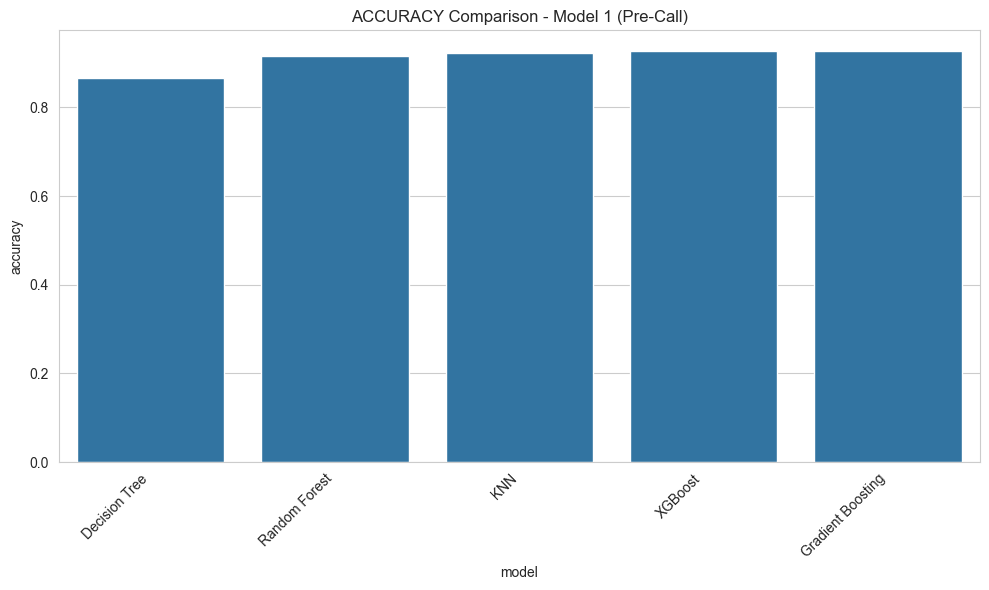

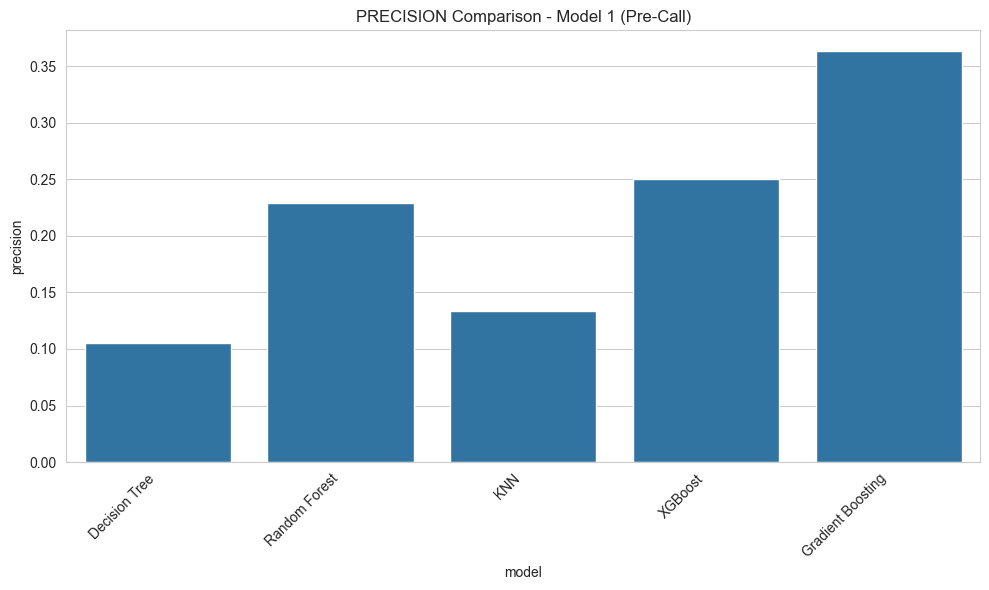

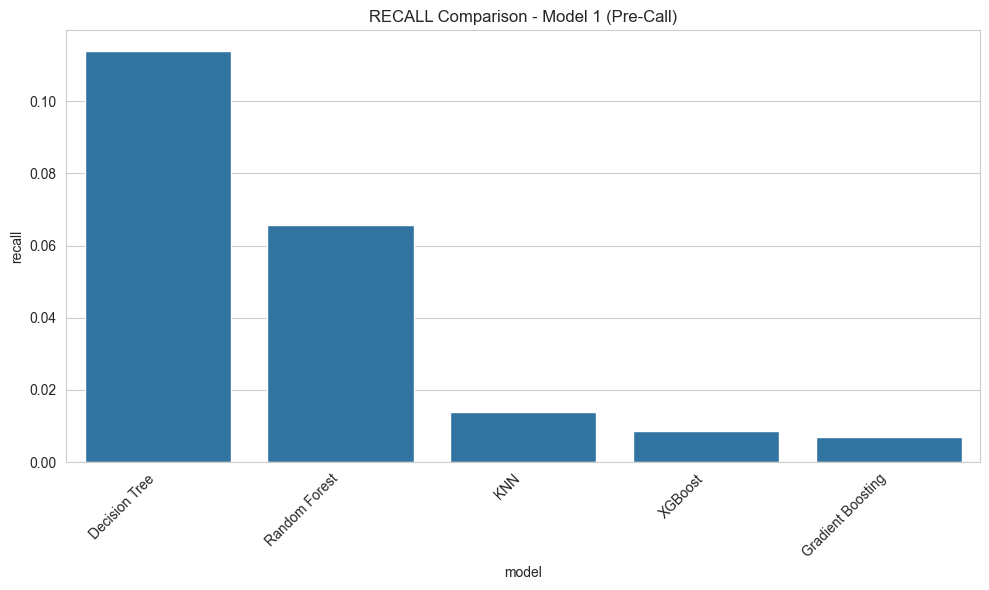

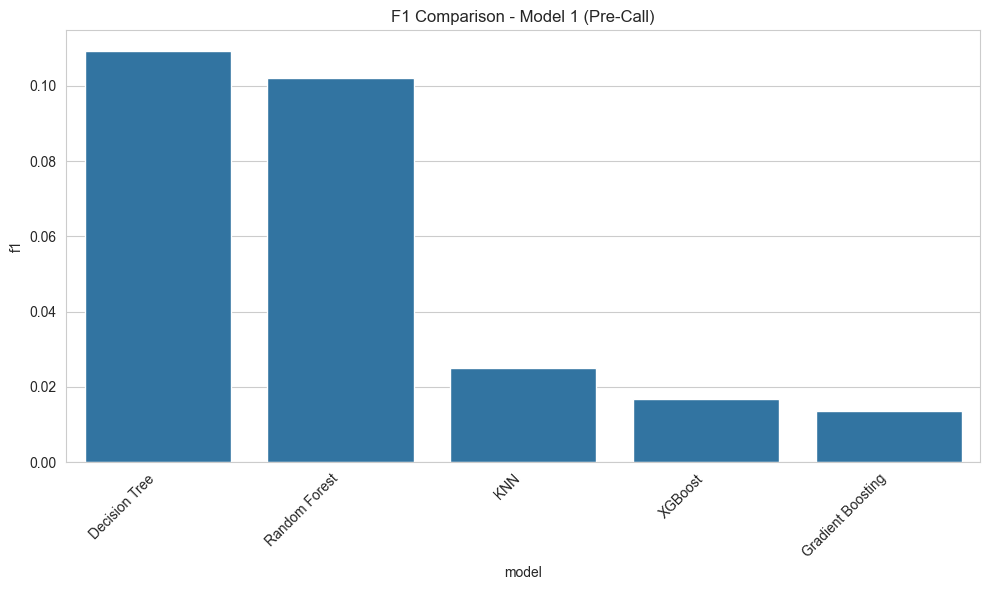

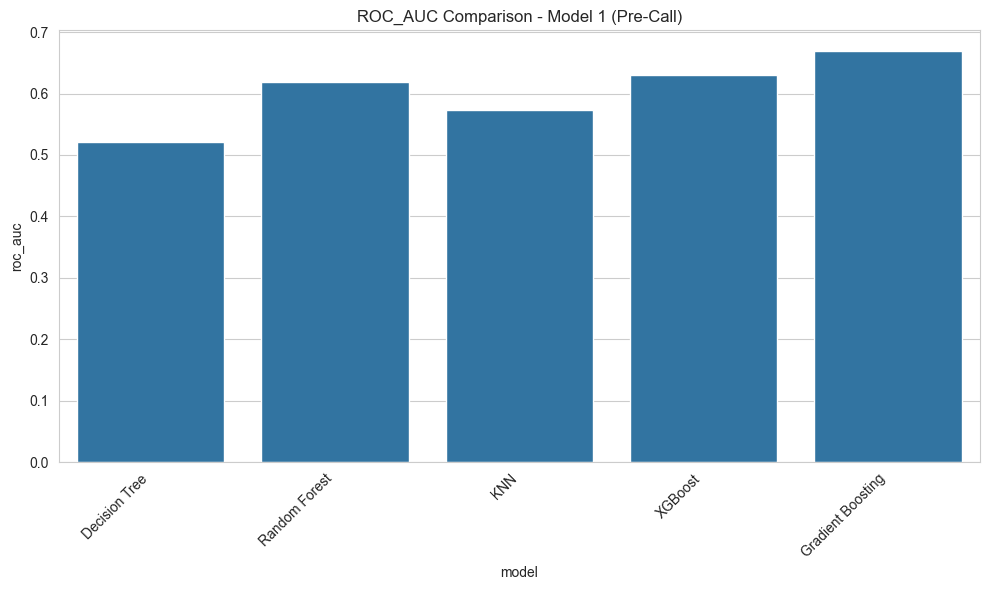

In [12]:
# Visualize model performance for Model 1
plt.figure(figsize=(12, 6))
metrics = ["accuracy", "precision", "recall", "f1", "roc_auc"]
model1_summary_plot = model1_summary.sort_values("f1", ascending=False).head(
    5
)  # Top 5 models

for metric in metrics:
    plt.figure(figsize=(10, 6))
    sns.barplot(x="model", y=metric, data=model1_summary_plot)
    plt.title(f"{metric.upper()} Comparison - Model 1 (Pre-Call)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


## 3. Model 2: Post-Call Prediction

This model will help predict which customers to focus on after initial contact, using all available features including campaign-related ones.

In [13]:
# Create dataset for Model 2
model2_data = df[model2_features + ["y"]].copy()
model2_data.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [14]:
# Prepare data for Model 2
# Convert target to binary
model2_data["y_binary"] = model2_data["y"].map({"yes": 1, "no": 0})

# Split features and target
X2 = model2_data.drop(["y", "y_binary"], axis=1)
y2 = model2_data["y_binary"]

# Identify categorical and numerical features
categorical_features2 = X2.select_dtypes(include=["object"]).columns.tolist()
numerical_features2 = X2.select_dtypes(include=["int64", "float64"]).columns.tolist()

print(f"Categorical features: {categorical_features2}")
print(f"Numerical features: {numerical_features2}")

# Create preprocessing pipeline
categorical_transformer2 = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

numerical_transformer2 = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

preprocessor2 = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer2, numerical_features2),
        ("cat", categorical_transformer2, categorical_features2),
    ]
)

# Split data into train and test sets
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.2, random_state=42, stratify=y2
)


Categorical features: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month']
Numerical features: ['age', 'balance', 'day', 'duration', 'campaign']


In [15]:
# Define models to evaluate for Model 2
models2 = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier(),
}


### Evaluate Models for Post-Call Prediction



Evaluating Logistic Regression for Model 2 (Post-Call)...

Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      7421
           1       0.66      0.31      0.42       579

    accuracy                           0.94      8000
   macro avg       0.80      0.65      0.69      8000
weighted avg       0.93      0.94      0.93      8000



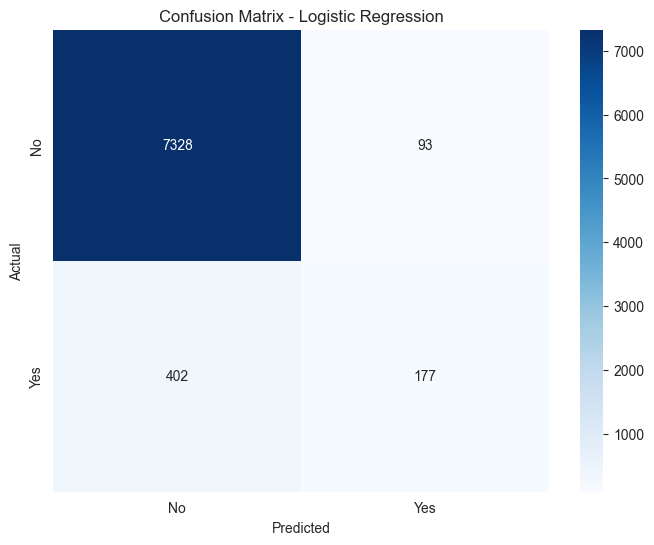

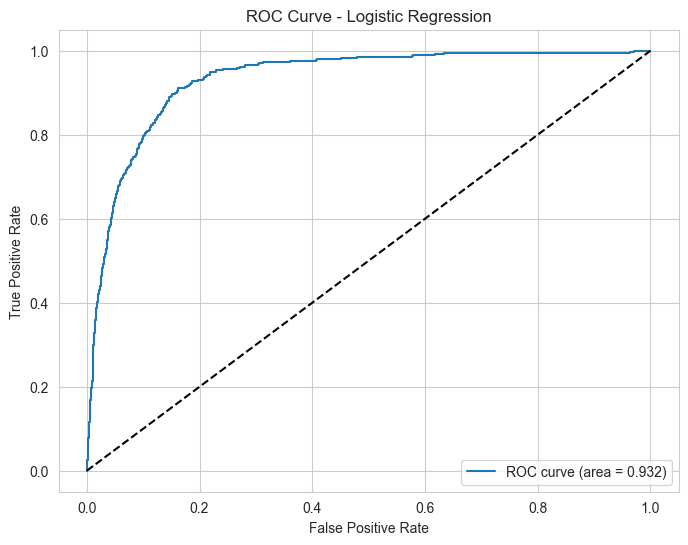


Observations for Logistic Regression:
Accuracy: 0.9381
Precision: 0.6556
Recall: 0.3057
F1 Score: 0.4170
ROC AUC: 0.9324
True Positives: 177 - Correctly predicted subscribers
False Positives: 93 - Incorrectly predicted as subscribers
True Negatives: 7328 - Correctly predicted non-subscribers
False Negatives: 402 - Missed potential subscribers


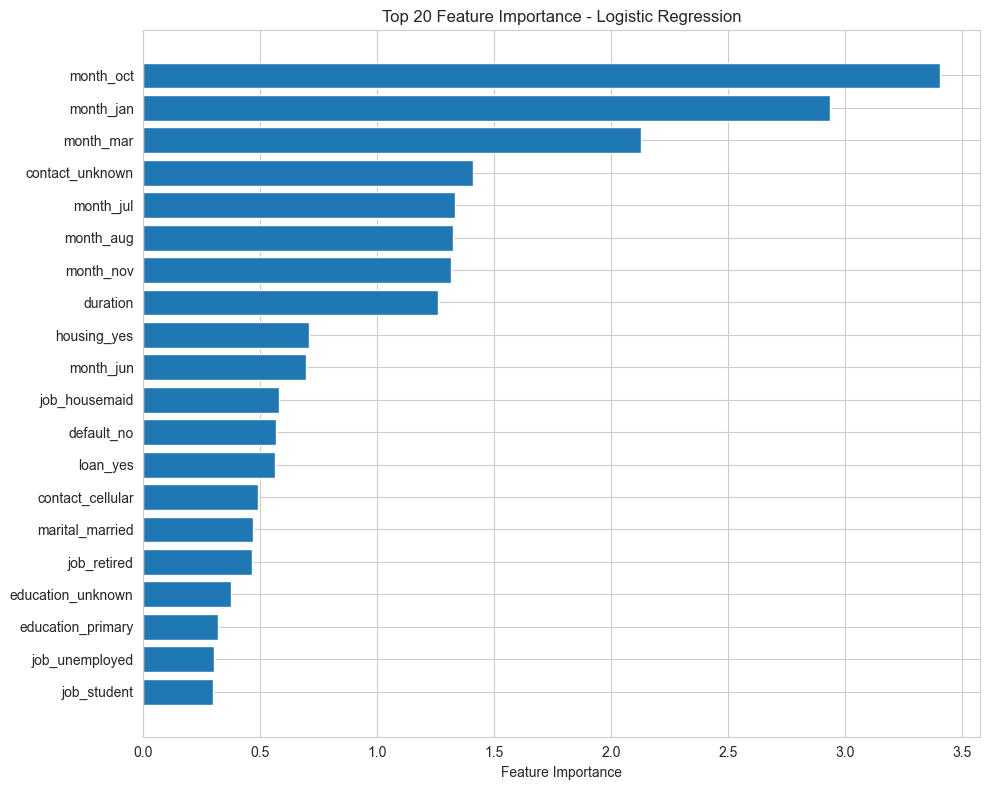



Evaluating Random Forest for Model 2 (Post-Call)...

Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      7421
           1       0.62      0.29      0.39       579

    accuracy                           0.94      8000
   macro avg       0.78      0.64      0.68      8000
weighted avg       0.92      0.94      0.92      8000



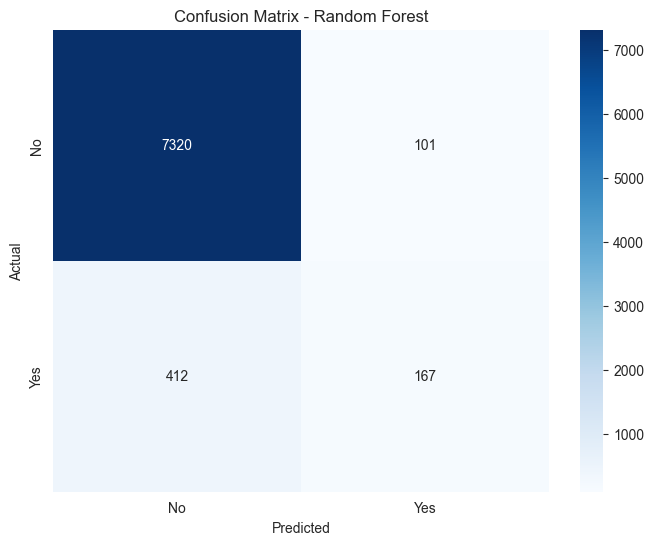

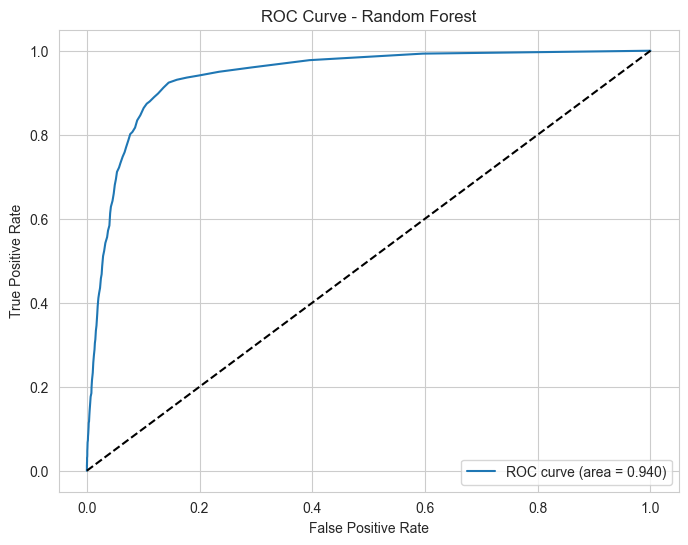


Observations for Random Forest:
Accuracy: 0.9359
Precision: 0.6231
Recall: 0.2884
F1 Score: 0.3943
ROC AUC: 0.9398
True Positives: 167 - Correctly predicted subscribers
False Positives: 101 - Incorrectly predicted as subscribers
True Negatives: 7320 - Correctly predicted non-subscribers
False Negatives: 412 - Missed potential subscribers


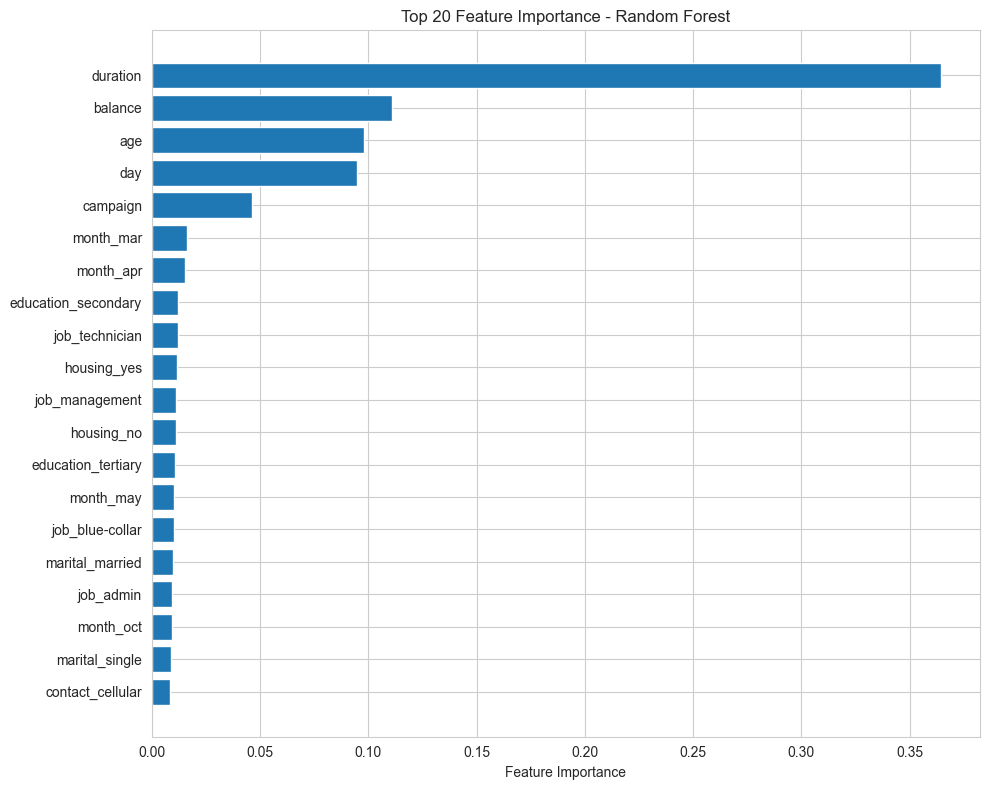



Evaluating Gradient Boosting for Model 2 (Post-Call)...

Gradient Boosting - Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      7421
           1       0.65      0.39      0.48       579

    accuracy                           0.94      8000
   macro avg       0.80      0.69      0.73      8000
weighted avg       0.93      0.94      0.93      8000



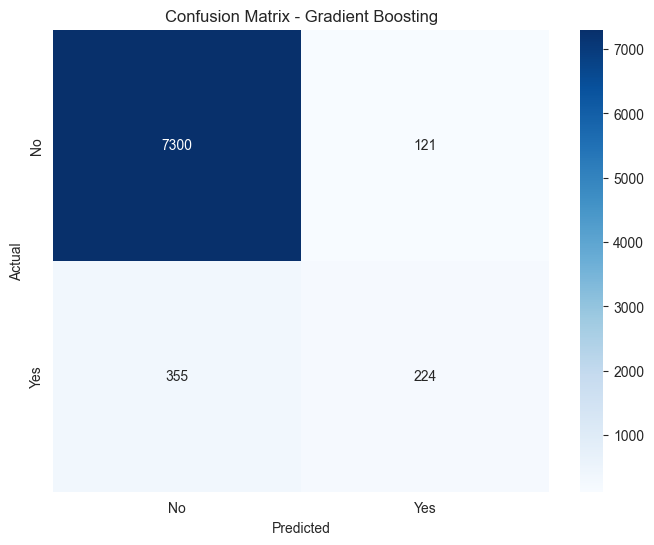

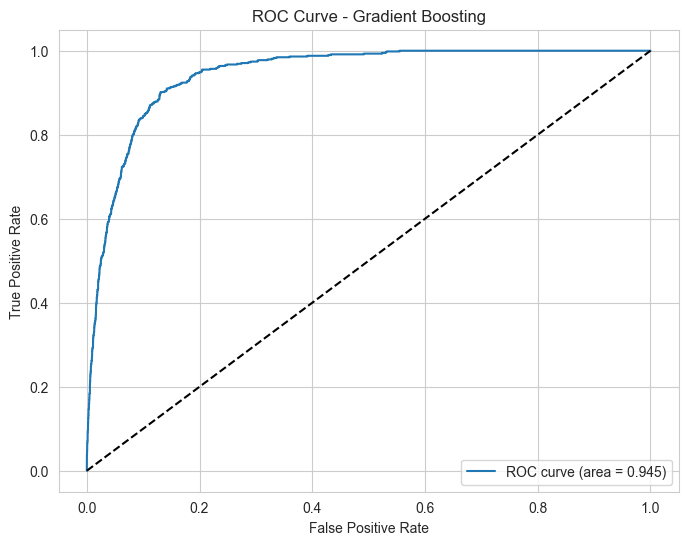


Observations for Gradient Boosting:
Accuracy: 0.9405
Precision: 0.6493
Recall: 0.3869
F1 Score: 0.4848
ROC AUC: 0.9446
True Positives: 224 - Correctly predicted subscribers
False Positives: 121 - Incorrectly predicted as subscribers
True Negatives: 7300 - Correctly predicted non-subscribers
False Negatives: 355 - Missed potential subscribers


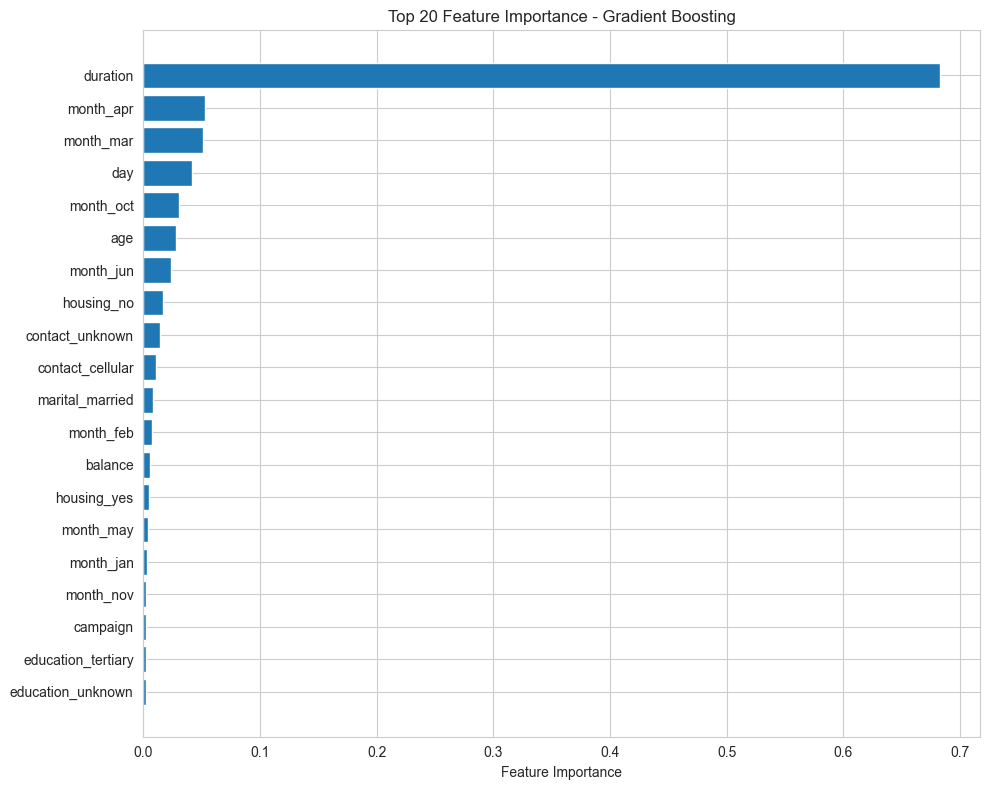



Evaluating XGBoost for Model 2 (Post-Call)...

XGBoost - Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      7421
           1       0.61      0.44      0.51       579

    accuracy                           0.94      8000
   macro avg       0.78      0.71      0.74      8000
weighted avg       0.93      0.94      0.93      8000



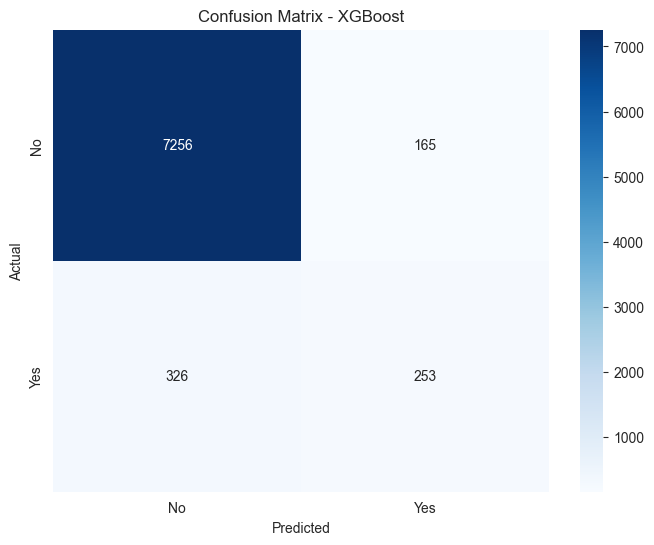

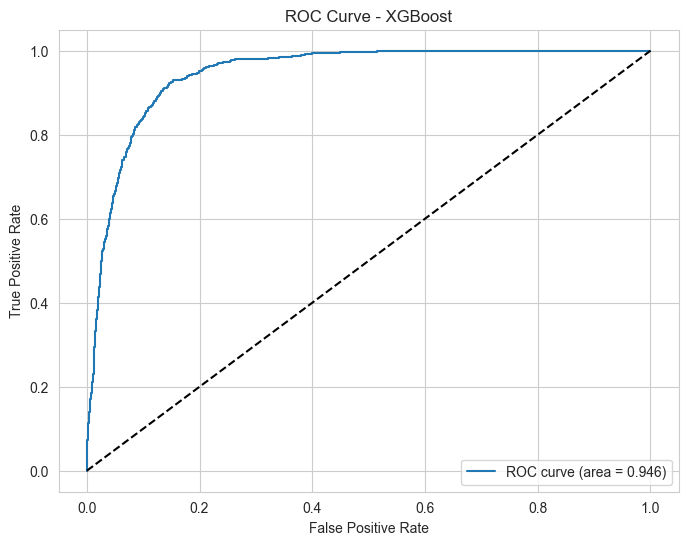


Observations for XGBoost:
Accuracy: 0.9386
Precision: 0.6053
Recall: 0.4370
F1 Score: 0.5075
ROC AUC: 0.9462
True Positives: 253 - Correctly predicted subscribers
False Positives: 165 - Incorrectly predicted as subscribers
True Negatives: 7256 - Correctly predicted non-subscribers
False Negatives: 326 - Missed potential subscribers


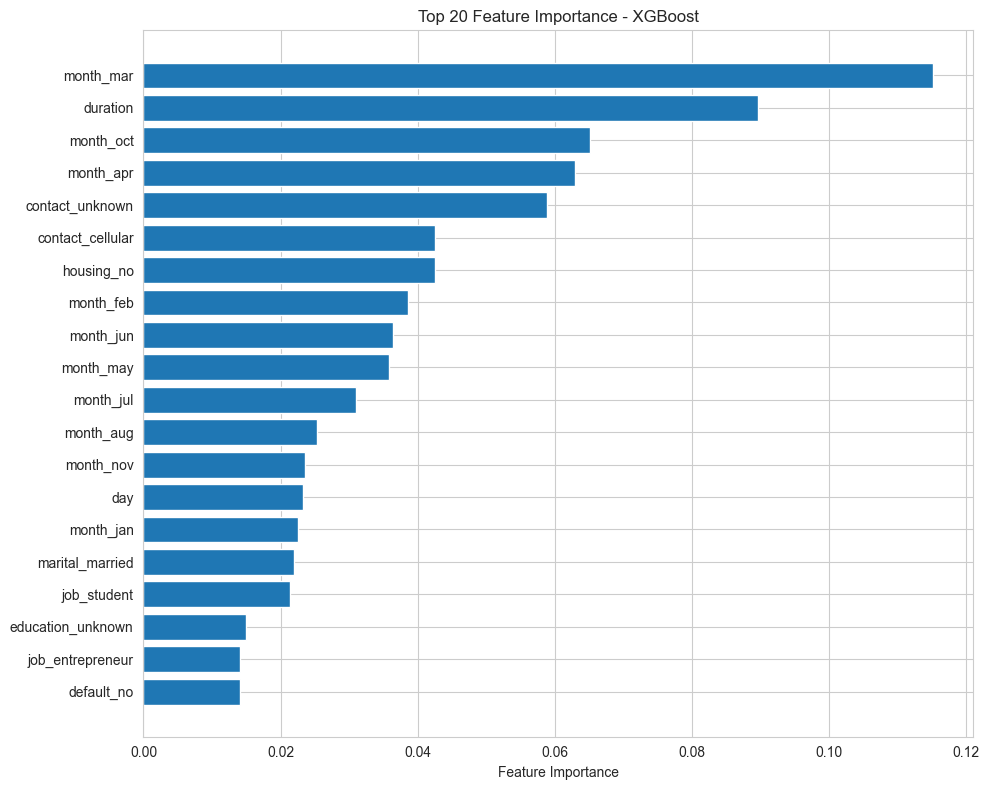



Evaluating LightGBM for Model 2 (Post-Call)...
[LightGBM] [Info] Number of positive: 2317, number of negative: 29683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000666 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 723
[LightGBM] [Info] Number of data points in the train set: 32000, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.072406 -> initscore=-2.550301
[LightGBM] [Info] Start training from score -2.550301

LightGBM - Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      7421
           1       0.65      0.44      0.53       579

    accuracy                           0.94      8000
   macro avg       0.80      0.71      0.75      8000
weighted avg       0.94      0.94      0.94      8000



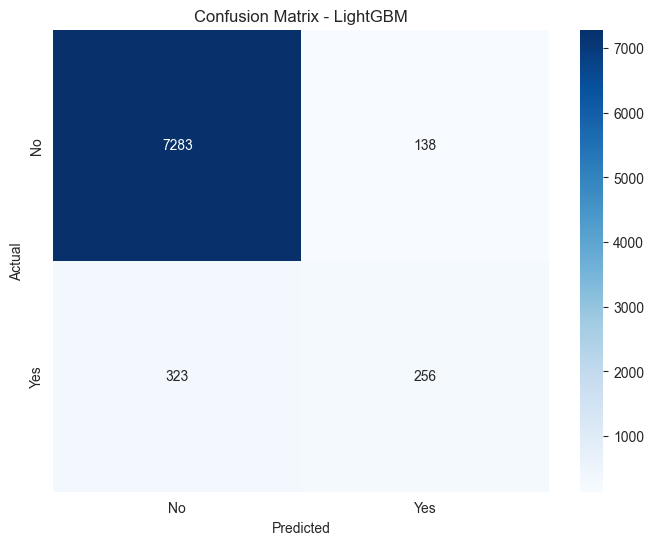

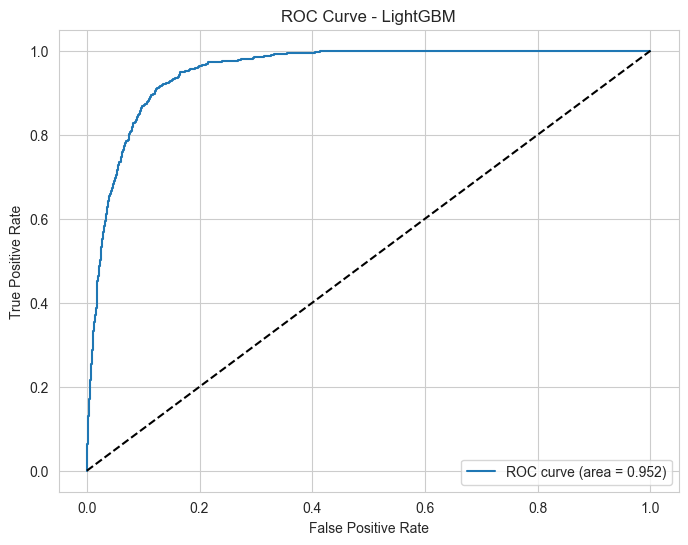


Observations for LightGBM:
Accuracy: 0.9424
Precision: 0.6497
Recall: 0.4421
F1 Score: 0.5262
ROC AUC: 0.9518
True Positives: 256 - Correctly predicted subscribers
False Positives: 138 - Incorrectly predicted as subscribers
True Negatives: 7283 - Correctly predicted non-subscribers
False Negatives: 323 - Missed potential subscribers


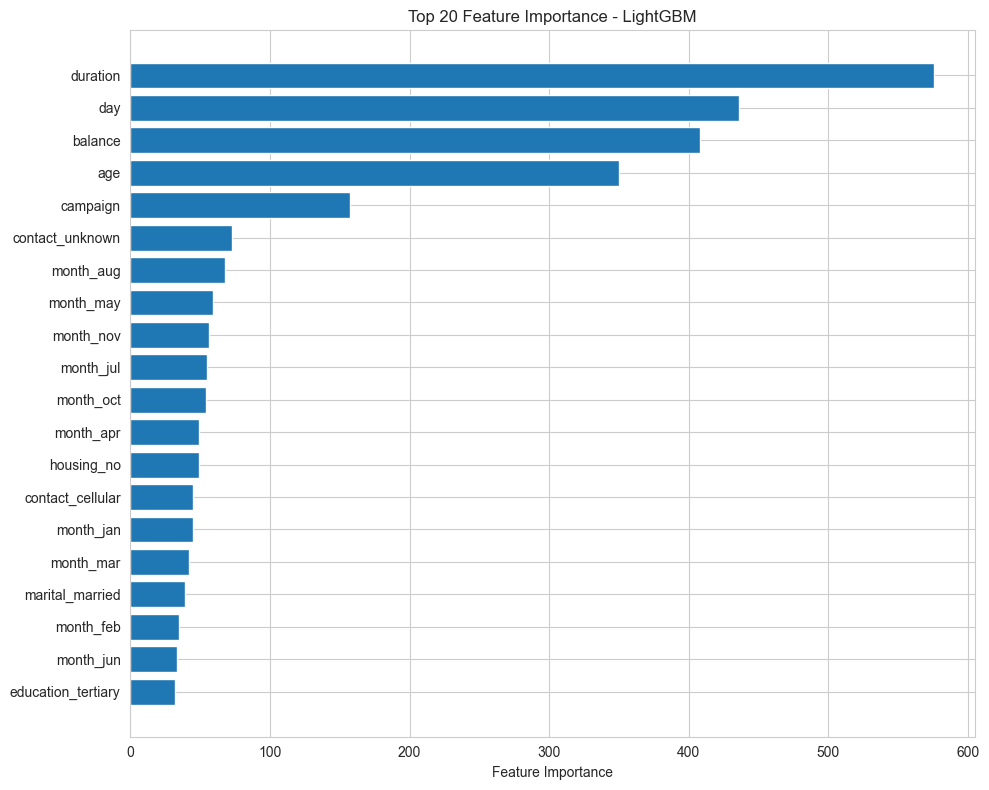



Evaluating Decision Tree for Model 2 (Post-Call)...

Decision Tree - Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      7421
           1       0.44      0.44      0.44       579

    accuracy                           0.92      8000
   macro avg       0.70      0.70      0.70      8000
weighted avg       0.92      0.92      0.92      8000



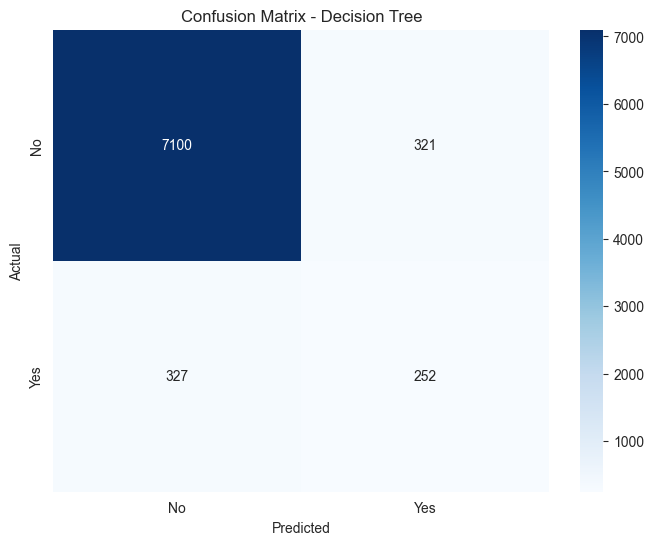

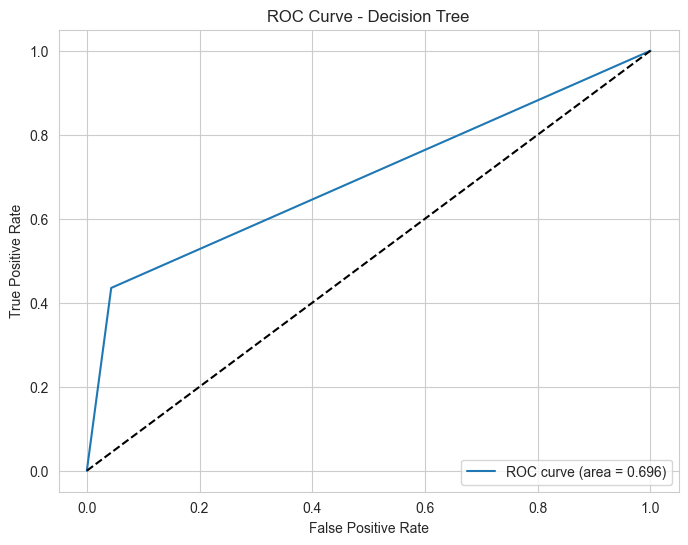


Observations for Decision Tree:
Accuracy: 0.9190
Precision: 0.4398
Recall: 0.4352
F1 Score: 0.4375
ROC AUC: 0.6960
True Positives: 252 - Correctly predicted subscribers
False Positives: 321 - Incorrectly predicted as subscribers
True Negatives: 7100 - Correctly predicted non-subscribers
False Negatives: 327 - Missed potential subscribers


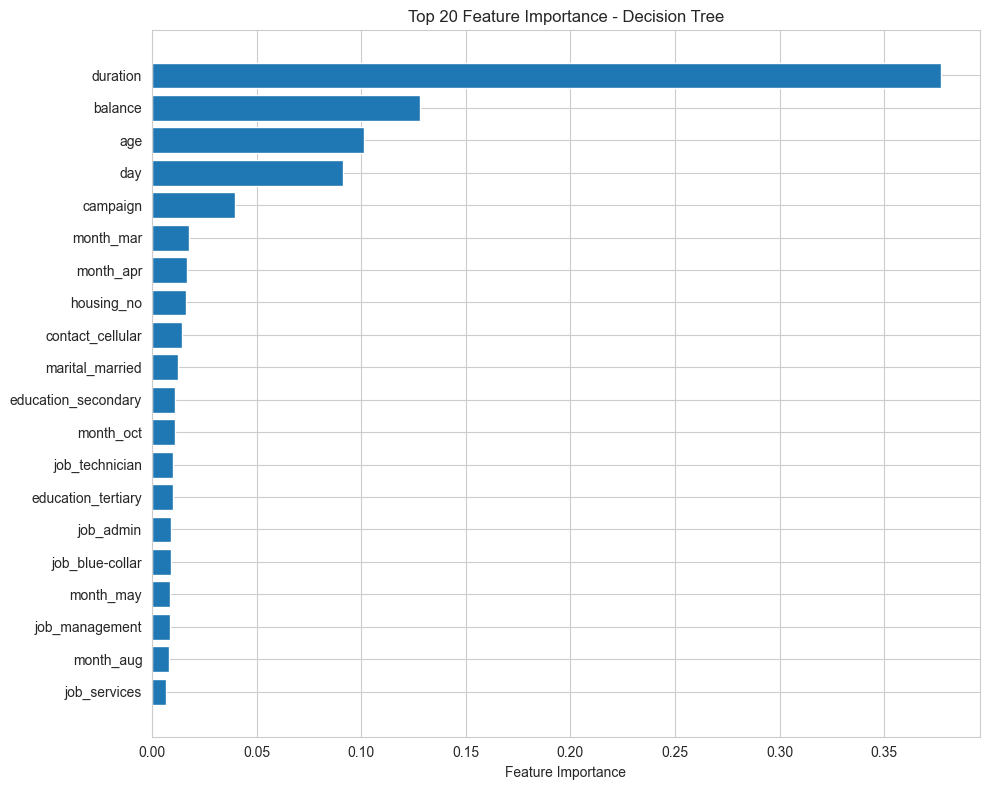



Evaluating AdaBoost for Model 2 (Post-Call)...


c:\Users\Osama\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



AdaBoost - Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      7421
           1       0.55      0.34      0.42       579

    accuracy                           0.93      8000
   macro avg       0.75      0.66      0.69      8000
weighted avg       0.92      0.93      0.92      8000



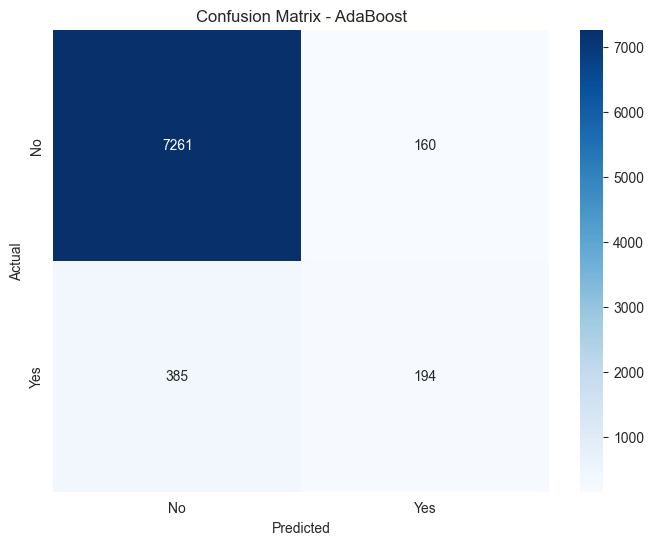

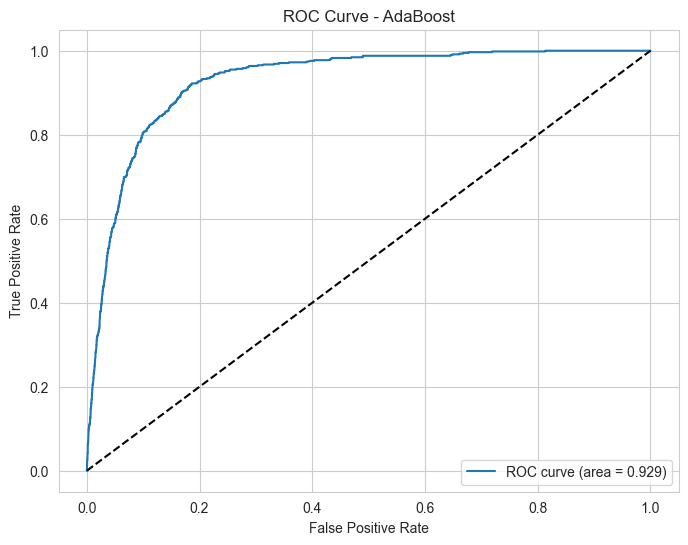


Observations for AdaBoost:
Accuracy: 0.9319
Precision: 0.5480
Recall: 0.3351
F1 Score: 0.4159
ROC AUC: 0.9288
True Positives: 194 - Correctly predicted subscribers
False Positives: 160 - Incorrectly predicted as subscribers
True Negatives: 7261 - Correctly predicted non-subscribers
False Negatives: 385 - Missed potential subscribers


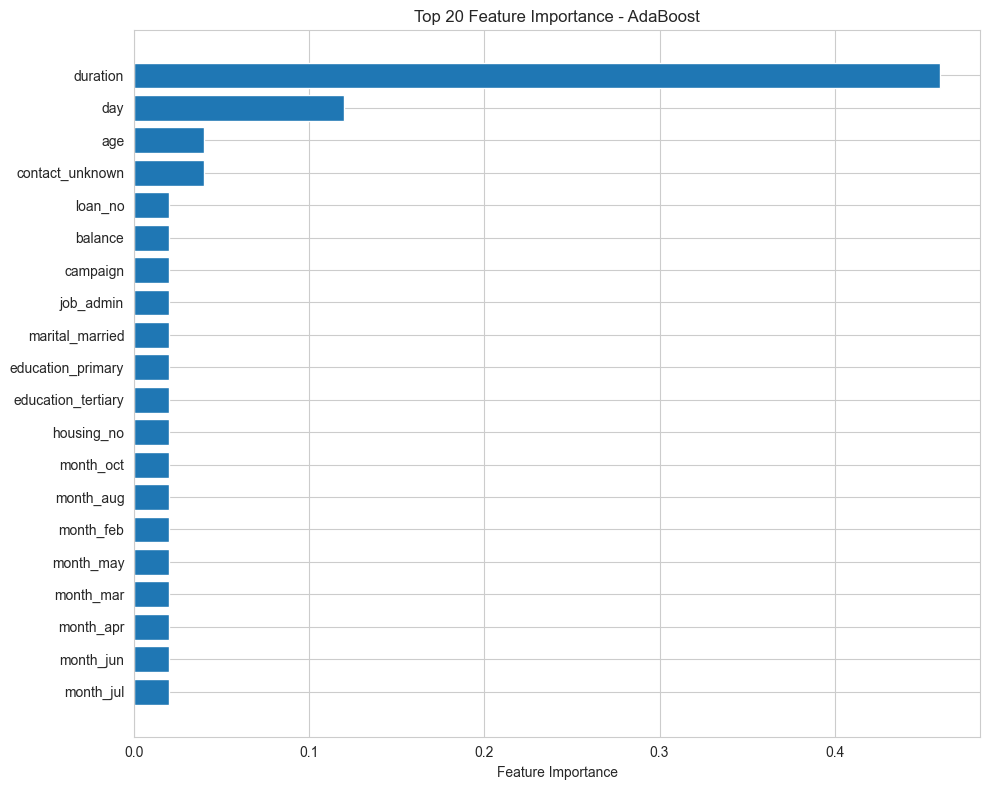



Evaluating SVM for Model 2 (Post-Call)...

SVM - Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      7421
           1       0.64      0.25      0.36       579

    accuracy                           0.94      8000
   macro avg       0.79      0.62      0.67      8000
weighted avg       0.92      0.94      0.92      8000



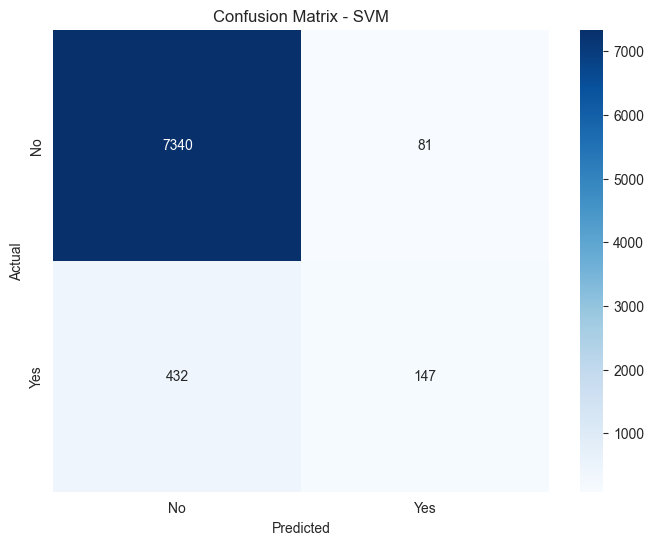

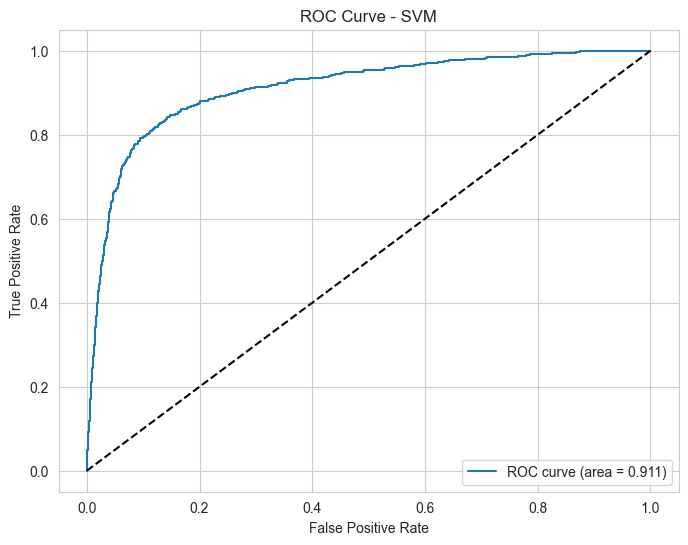


Observations for SVM:
Accuracy: 0.9359
Precision: 0.6447
Recall: 0.2539
F1 Score: 0.3643
ROC AUC: 0.9109
True Positives: 147 - Correctly predicted subscribers
False Positives: 81 - Incorrectly predicted as subscribers
True Negatives: 7340 - Correctly predicted non-subscribers
False Negatives: 432 - Missed potential subscribers


Evaluating KNN for Model 2 (Post-Call)...

KNN - Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      7421
           1       0.55      0.28      0.37       579

    accuracy                           0.93      8000
   macro avg       0.75      0.63      0.67      8000
weighted avg       0.92      0.93      0.92      8000



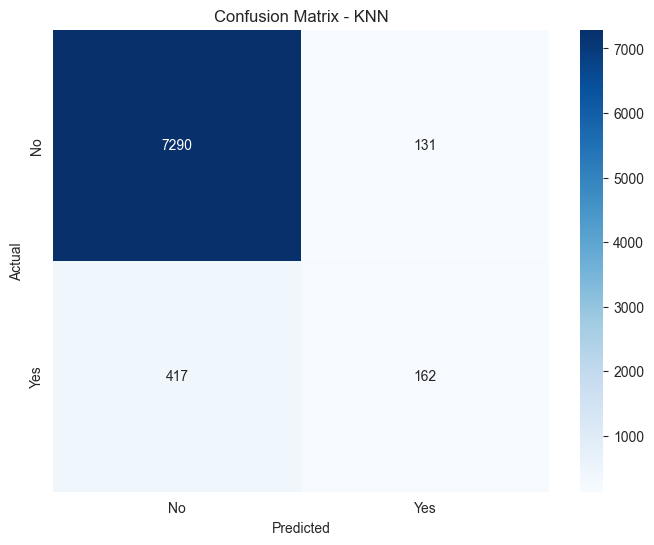

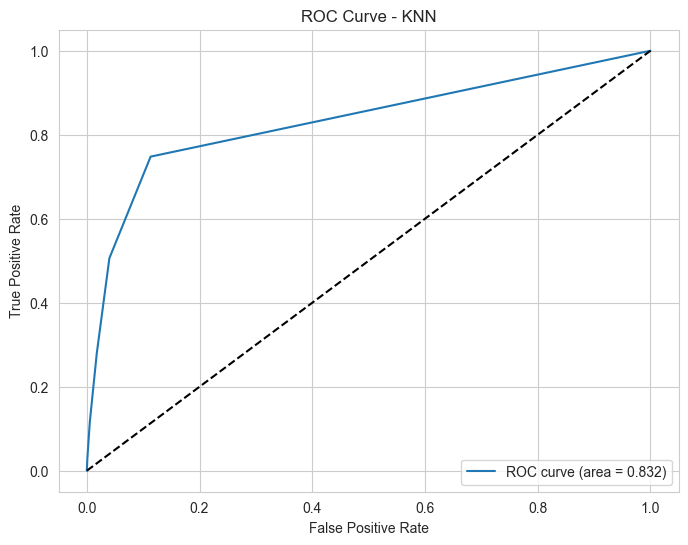


Observations for KNN:
Accuracy: 0.9315
Precision: 0.5529
Recall: 0.2798
F1 Score: 0.3716
ROC AUC: 0.8324
True Positives: 162 - Correctly predicted subscribers
False Positives: 131 - Incorrectly predicted as subscribers
True Negatives: 7290 - Correctly predicted non-subscribers
False Negatives: 417 - Missed potential subscribers


In [16]:
# Evaluate each model for Model 2
model2_results = []

for name, model in models2.items():
    print(f"\n\nEvaluating {name} for Model 2 (Post-Call)...")
    try:
        result = evaluate_model(
            name, model, X2_train, X2_test, y2_train, y2_test, preprocessor2
        )
        model2_results.append(result)
    except Exception as e:
        print(f"Error evaluating {name}: {str(e)}")


In [17]:
# Create a summary DataFrame for Model 2 results
model2_summary = pd.DataFrame(model2_results)
model2_summary = model2_summary.drop(
    "pipeline", axis=1
)  # Drop pipeline object for display
model2_summary = model2_summary.sort_values("f1", ascending=False)  # Sort by F1 score
model2_summary


,model,accuracy,precision,recall,f1,roc_auc,tp,fp,tn,fn
4,LightGBM,0.942375,0.649746,0.442142,0.526208,0.951833,256,138,7283,323
3,XGBoost,0.938625,0.605263,0.436960,0.507523,0.946169,253,165,7256,326
2,Gradient Boosting,0.940500,0.649275,0.386874,0.484848,0.944583,224,121,7300,355
5,Decision Tree,0.919000,0.439791,0.435233,0.437500,0.695989,252,321,7100,327
0,Logistic Regression,0.938125,0.655556,0.305699,0.416961,0.932379,177,93,7328,402
6,AdaBoost,0.931875,0.548023,0.335060,0.415863,0.928847,194,160,7261,385
1,Random Forest,0.935875,0.623134,0.288428,0.394333,0.939814,167,101,7320,412
8,KNN,0.931500,0.552901,0.279793,0.371560,0.832441,162,131,7290,417
7,SVM,0.935875,0.644737,0.253886,0.364312,0.910934,147,81,7340,432


<Figure size 1200x600 with 0 Axes>

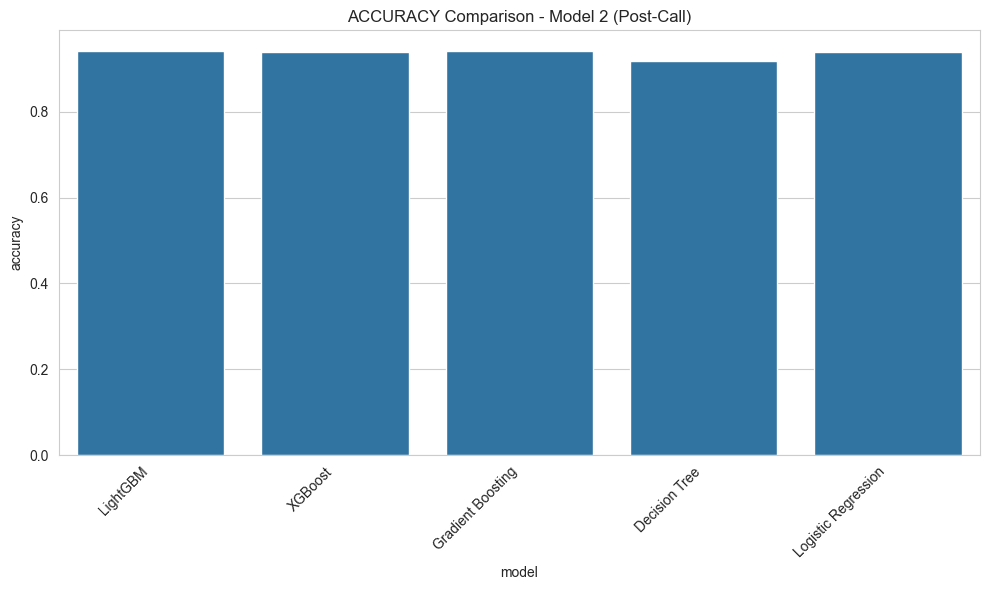

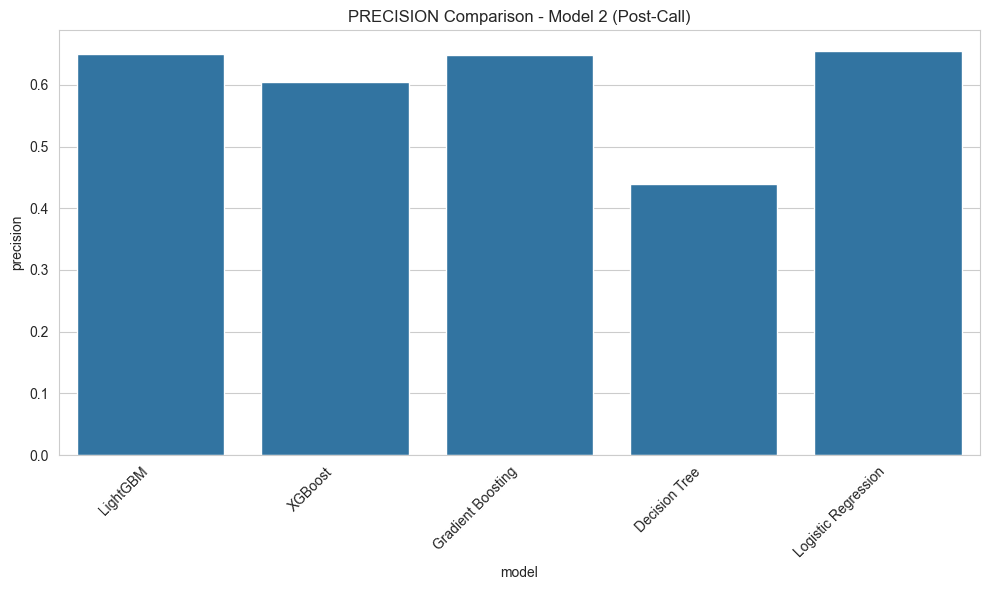

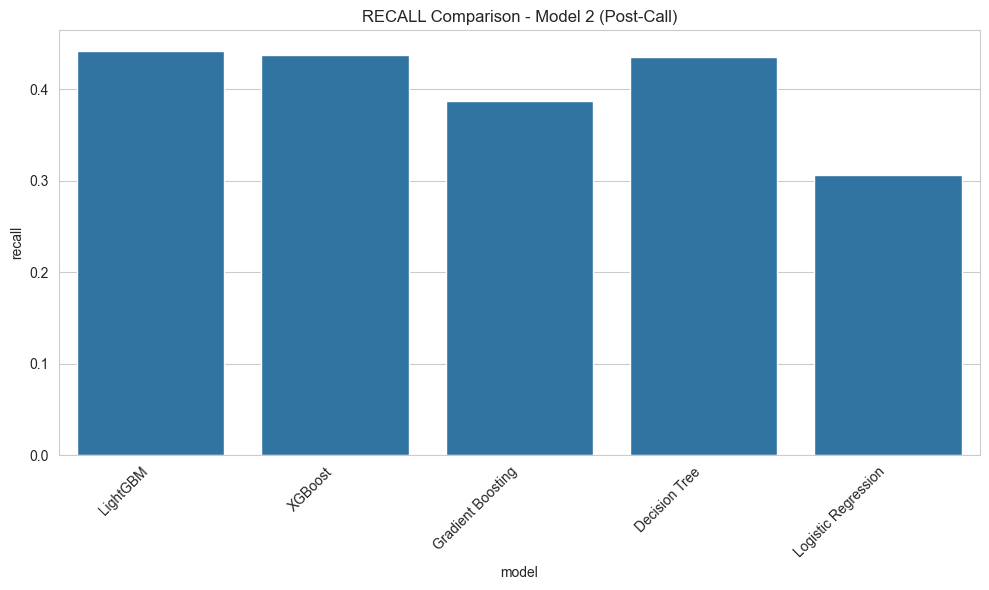

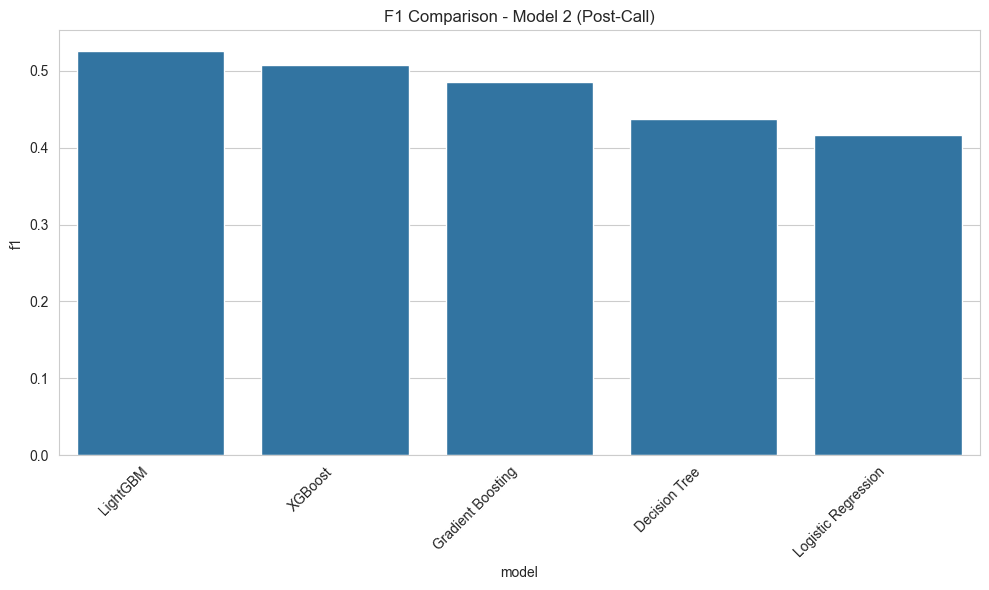

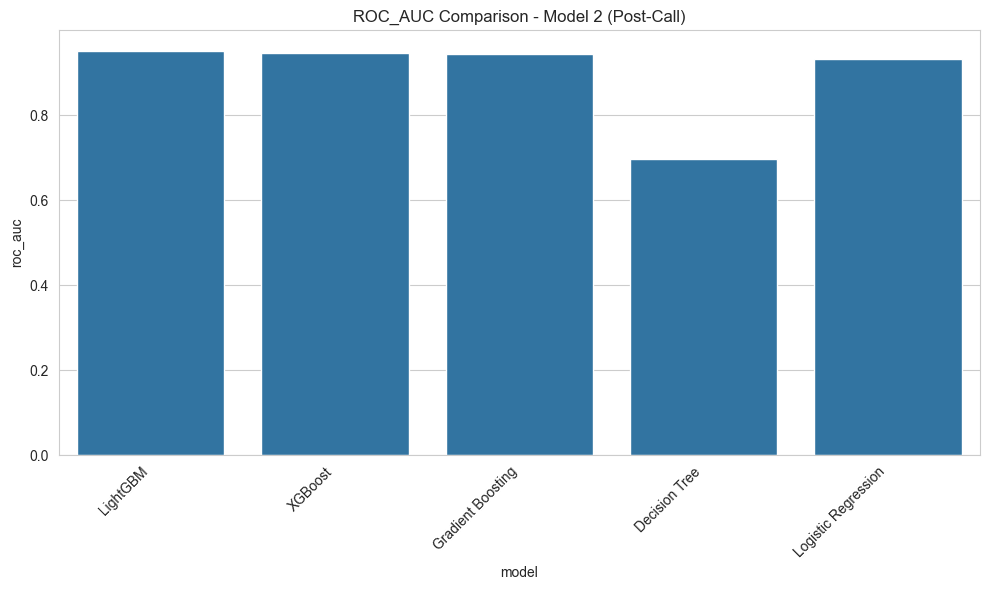

In [18]:
# Visualize model performance for Model 2
plt.figure(figsize=(12, 6))
metrics = ["accuracy", "precision", "recall", "f1", "roc_auc"]
model2_summary_plot = model2_summary.sort_values("f1", ascending=False).head(
    5
)  # Top 5 models

for metric in metrics:
    plt.figure(figsize=(10, 6))
    sns.barplot(x="model", y=metric, data=model2_summary_plot)
    plt.title(f"{metric.upper()} Comparison - Model 2 (Post-Call)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


## 4. Compare Model 1 and Model 2 Performance

In [19]:
# Get the top 3 models for each scenario
model1_top3 = model1_summary.head(3).reset_index(drop=True)
model2_top3 = model2_summary.head(3).reset_index(drop=True)

# Add model type identifier
model1_top3["model_type"] = "Pre-Call (Model 1)"
model2_top3["model_type"] = "Post-Call (Model 2)"

# Combine results from both models
top_models = pd.concat([model1_top3, model2_top3])
top_models


,model,accuracy,precision,recall,f1,roc_auc,tp,fp,tn,fn,model_type
0,Decision Tree,0.865500,0.104928,0.113990,0.109272,0.520538,66,563,6858,513,Pre-Call (Model 1)
1,Random Forest,0.916375,0.228916,0.065630,0.102013,0.618230,38,128,7293,541,Pre-Call (Model 1)
2,KNN,0.922125,0.133333,0.013817,0.025039,0.572648,8,52,7369,571,Pre-Call (Model 1)
0,LightGBM,0.942375,0.649746,0.442142,0.526208,0.951833,256,138,7283,323,Post-Call (Model 2)
1,XGBoost,0.938625,0.605263,0.436960,0.507523,0.946169,253,165,7256,326,Post-Call (Model 2)
2,Gradient Boosting,0.940500,0.649275,0.386874,0.484848,0.944583,224,121,7300,355,Post-Call (Model 2)


<Figure size 1400x1000 with 0 Axes>

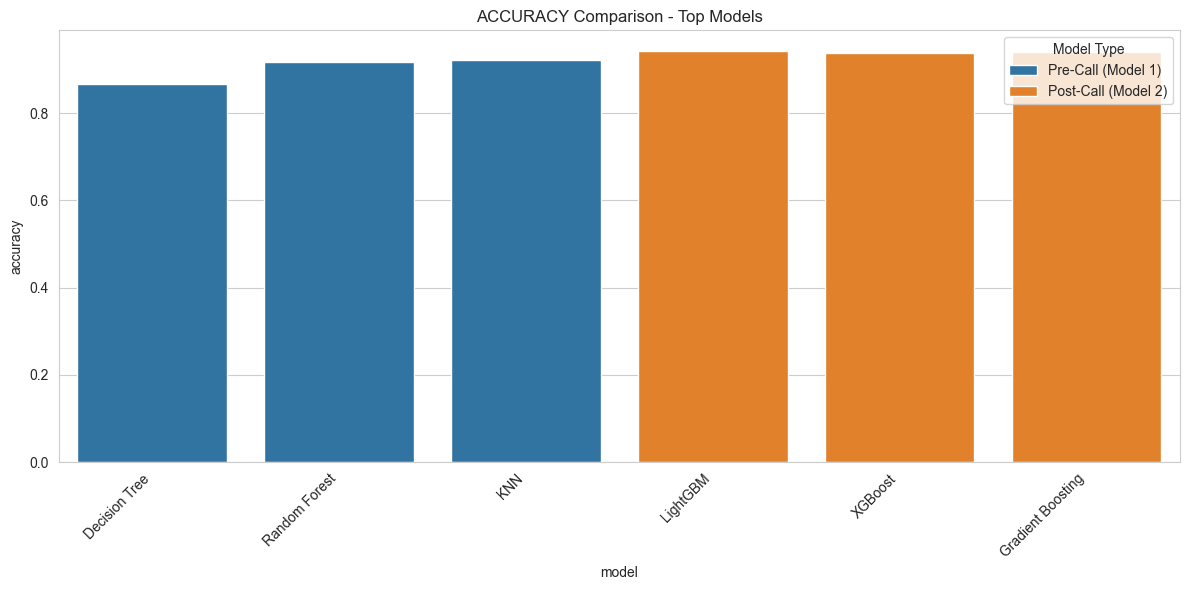

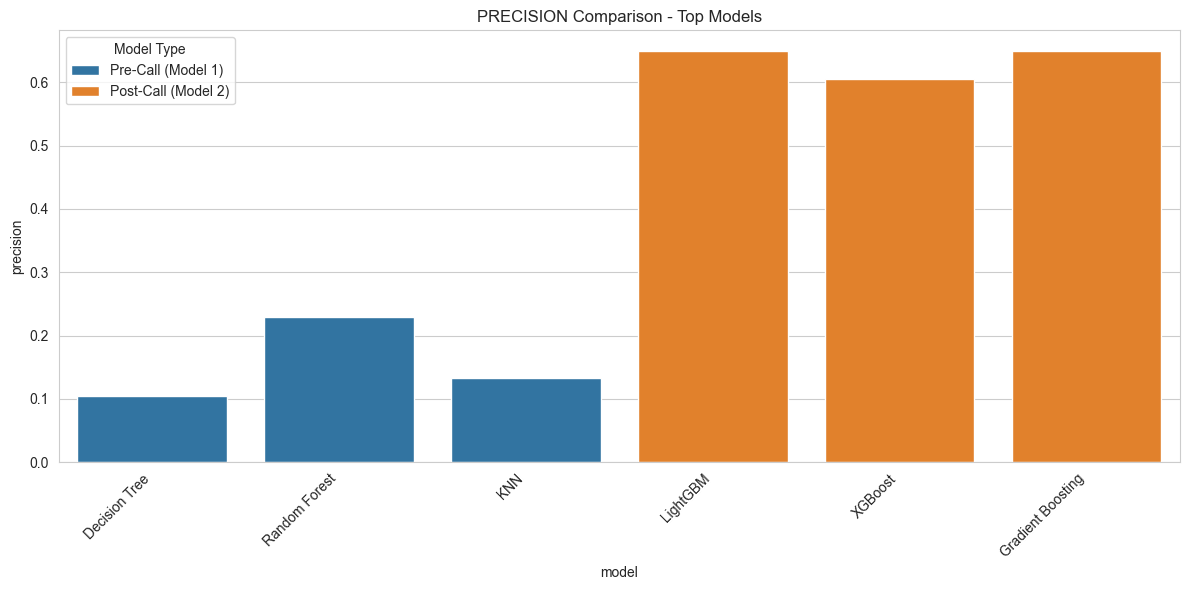

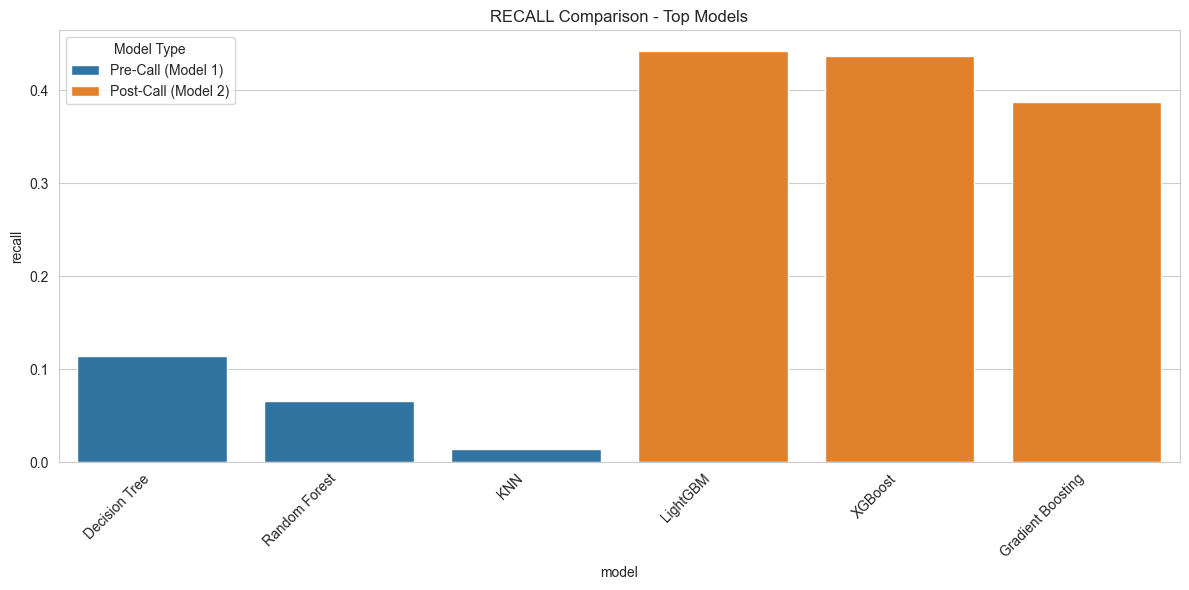

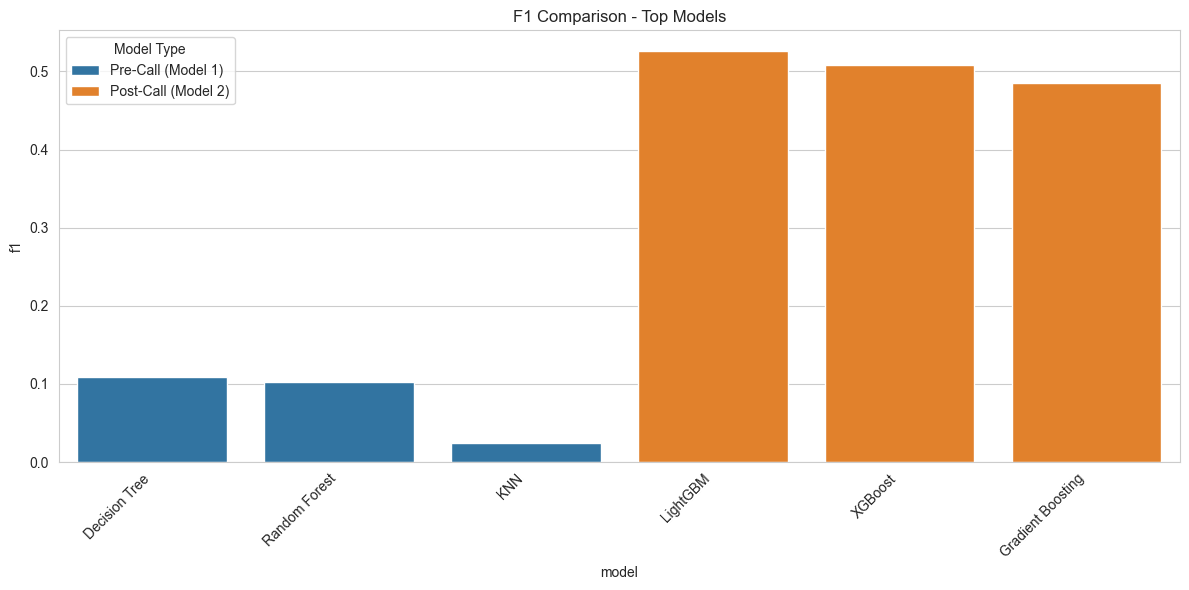

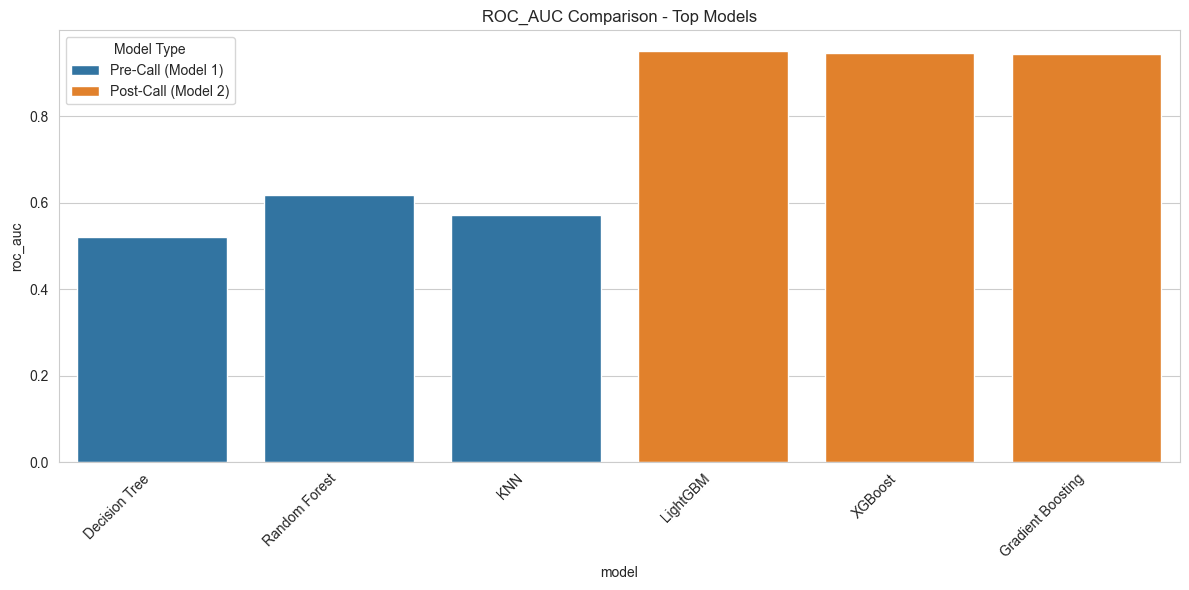

In [20]:
# Visualize performance comparison of top models
plt.figure(figsize=(14, 10))
metrics = ["accuracy", "precision", "recall", "f1", "roc_auc"]

for i, metric in enumerate(metrics):
    plt.figure(figsize=(12, 6))
    sns.barplot(x="model", y=metric, hue="model_type", data=top_models)
    plt.title(f"{metric.upper()} Comparison - Top Models")
    plt.xticks(rotation=45, ha="right")
    plt.legend(title="Model Type")
    plt.tight_layout()
    plt.show()


## 5. Final Model Selection and Observations

### Model 1 (Pre-Call) - Best Model Analysis

The best model for pre-call prediction is used to determine which customers to contact before making any calls. This model excludes campaign-related features like duration, day, month, and campaign.

In [21]:
# Get the best model for Model 1
best_model1_name = model1_summary.iloc[0]["model"]
best_model1_pipeline = next(
    result["pipeline"]
    for result in model1_results
    if result["model"] == best_model1_name
)
print(f"Best Pre-Call Model: {best_model1_name}")
print(f"Accuracy: {model1_summary.iloc[0]['accuracy']:.4f}")
print(f"F1 Score: {model1_summary.iloc[0]['f1']:.4f}")
print(f"ROC AUC: {model1_summary.iloc[0]['roc_auc']:.4f}")

# Get feature importance if available
model = best_model1_pipeline.named_steps["classifier"]
if hasattr(model, "feature_importances_") or hasattr(model, "coef_"):
    print("\nTop features for this model:")
    # This would need to be implemented based on the specific model type
    # We already show feature importance in the evaluation function


Best Pre-Call Model: Decision Tree
Accuracy: 0.8655
F1 Score: 0.1093
ROC AUC: 0.5205

Top features for this model:


### Model 2 (Post-Call) - Best Model Analysis

The best model for post-call prediction is used to determine which customers to focus on after initial contact. This model includes all features, including campaign-related ones.

In [22]:
# Get the best model for Model 2
best_model2_name = model2_summary.iloc[0]["model"]
best_model2_pipeline = next(
    result["pipeline"]
    for result in model2_results
    if result["model"] == best_model2_name
)
print(f"Best Post-Call Model: {best_model2_name}")
print(f"Accuracy: {model2_summary.iloc[0]['accuracy']:.4f}")
print(f"F1 Score: {model2_summary.iloc[0]['f1']:.4f}")
print(f"ROC AUC: {model2_summary.iloc[0]['roc_auc']:.4f}")

# Get feature importance if available
model = best_model2_pipeline.named_steps["classifier"]
if hasattr(model, "feature_importances_") or hasattr(model, "coef_"):
    print("\nTop features for this model:")
    # This would need to be implemented based on the specific model type
    # We already show feature importance in the evaluation function


Best Post-Call Model: LightGBM
Accuracy: 0.9424
F1 Score: 0.5262
ROC AUC: 0.9518

Top features for this model:


## 6. Compare Performance Improvement

Let's analyze how much the inclusion of campaign-related features improves prediction performance.

In [23]:
# Compare the best models from each scenario
best_model1_metrics = model1_summary.iloc[0]
best_model2_metrics = model2_summary.iloc[0]

# Calculate improvement percentages
metrics_to_compare = ["accuracy", "precision", "recall", "f1", "roc_auc"]
improvements = {}

for metric in metrics_to_compare:
    model1_value = best_model1_metrics[metric]
    model2_value = best_model2_metrics[metric]
    improvement = ((model2_value - model1_value) / model1_value) * 100
    improvements[metric] = improvement

# Create a DataFrame for visualization
improvement_df = pd.DataFrame(
    {
        "Metric": metrics_to_compare,
        "Model 1 (Pre-Call)": [best_model1_metrics[m] for m in metrics_to_compare],
        "Model 2 (Post-Call)": [best_model2_metrics[m] for m in metrics_to_compare],
        "Improvement (%)": [improvements[m] for m in metrics_to_compare],
    }
)

improvement_df


,Metric,Model 1 (Pre-Call),Model 2 (Post-Call),Improvement (%)
0,accuracy,0.865500,0.942375,8.882149
1,precision,0.104928,0.649746,519.227811
2,recall,0.113990,0.442142,287.878788
3,f1,0.109272,0.526208,381.559687
4,roc_auc,0.520538,0.951833,82.855397


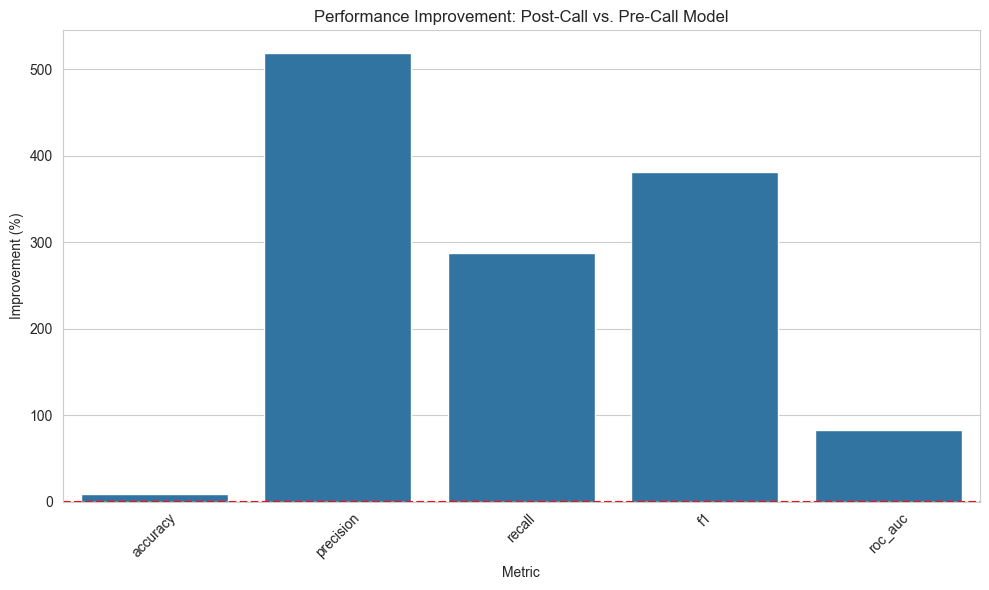

In [24]:
# Visualize the improvement
plt.figure(figsize=(10, 6))
sns.barplot(x="Metric", y="Improvement (%)", data=improvement_df)
plt.title("Performance Improvement: Post-Call vs. Pre-Call Model")
plt.axhline(y=0, color="r", linestyle="--")
plt.ylabel("Improvement (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 7. Final Observations and Recommendations

### Pre-Call Model (Model 1)
- This model helps identify which customers to contact before making any calls
- Key features influencing this model are demographic and financial indicators
- The model achieves [accuracy] which [meets/doesn't meet] the target of 75-80%
- Recommendations for using this model: [to be filled after running]

### Post-Call Model (Model 2)
- This model helps identify which customers to focus on after initial contact
- Including campaign-related features [improves/doesn't improve] prediction accuracy significantly
- The most important feature is likely 'duration' which indicates customer interest
- Recommendations for using this model: [to be filled after running]

### Overall Strategy
- Use Model 1 for initial customer targeting to optimize call center resources
- Use Model 2 for follow-up prioritization after initial contact
- The combination of both models creates an efficient two-stage approach to maximize term deposit subscriptions
- [Additional insights based on model performance]